# Autoencoder using fastai V2

## setup

In [ ]:
#!pip install -Uqq fastai fastcore
32*128

In [ ]:
import fastai
fastai.__version__

'2.2.2'

In [ ]:
from fastai.test_utils import show_install
show_install()



```text
=== Software === 
python        : 3.8.5
fastai        : 2.2.2
fastprogress  : 0.2.7
torch         : 1.7.0
nvidia driver : 455.38
torch cuda    : 11.0 / is available
torch cudnn   : 8003 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : GeForce RTX 2070 SUPER

=== Environment === 
platform      : Linux-5.8.0-7630-generic-x86_64-with-glibc2.10
distro        : #32~1609193707~20.10~781bb80-Ubuntu SMP Tue Jan 5 21:29:56 UTC 2
conda env     : fastbook
python        : /home/ergonyc/anaconda3/envs/fastbook/bin/python
sys.path      : /home/ergonyc/Projects/Project2.0/snkr-finder
/home/ergonyc/anaconda3/envs/fastbook/lib/python38.zip
/home/ergonyc/anaconda3/envs/fastbook/lib/python3.8
/home/ergonyc/anaconda3/envs/fastbook/lib/python3.8/lib-dynload

/home/ergonyc/anaconda3/envs/fastbook/lib/python3.8/site-packages
/home/ergonyc/anaconda3/envs/fastbook/lib/python3.8/site-packages/IPython/extensions
/home/ergonyc/.ipython
```

Please make sure to include 

In [ ]:
from fastai.vision.all import *
#import torchvision 


## Using  fastai V2: data pipelining
- Datablock API
- check that tfms are applied to input/target
- labeling func: `lambda o: o`

In [ ]:
#path = untar_data(URLs.MNIST_SAMPLE)

# load our core data
filename = "zappos-50k-simplified_sort" # no features
filename = "full_db" # no features


df = pd.read_pickle(f"data/{filename}.pkl")


# Lets be ready to test a few different sizes
IMG_SIZE_LG = 224
IMG_SIZE_MD = 160
IMG_SIZE_SM = 128

IMG_SIZE = IMG_SIZE_MD

IMG_SIZES = {"small":  IMG_SIZE_SM,
             "medium": IMG_SIZE_MD,
             "large":  IMG_SIZE_LG}

In [ ]:
np.random.seed(3333)
torch.manual_seed(3333)

image_path = Path("/home/ergonyc/Projects/Project2.0/snkr-finder/data/")
#image_path = Path("data/")
batch_size = 32



In [ ]:

df = df[["path","train","test","validate","t_t_v"]]

# I could remove all the "test" rows... for now i'll choose an alternate strategy:
# Drop all the "test" rows for now, and create an "is_valid" column...
# should probably drop a ton of columns to jus tkeep the file paths...
# just keep what we'll need below
df.loc[:,'is_valid']= df.test | df.validate


In [ ]:
L([image_path/d for d in df.path])

(#35566) [Path('/home/ergonyc/Projects/Project2.0/snkr-finder/data/Boots/Ankle/A. Testoni/7965307.5291.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkr-finder/data/Boots/Ankle/A. Testoni/7999255.363731.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkr-finder/data/Boots/Ankle/A. Testoni/8000978.364150.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkr-finder/data/Boots/Ankle/AIGLE/8113228.1897.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkr-finder/data/Boots/Ankle/AIGLE/8113228.1912.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkr-finder/data/Boots/Ankle/AIGLE/8113228.3.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkr-finder/data/Boots/Ankle/ALDO/8045630.60941.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkr-finder/data/Boots/Ankle/ALDO/8045637.3.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkr-finder/data/Boots/Ankle/ALDO/8045654.3.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkr-finder/data/Boots/Ankle/ALDO/8045660.3.jpg')...]

In [ ]:
# some helper functions borrowed from validating the feature embedding
def get_x(r): return image_path/r['path']
#def get_y(r): return r['Category']
get_y = get_x  

def splitter(df):
    train = df.index[df['train']]
    valid = df.index[df['validate']]
    return train,valid


batch_tfms = Normalize.from_stats(*imagenet_stats)
rand_tfms = aug_transforms(mult=1.0, 
               do_flip=True, 
               flip_vert=False, 
               max_rotate=3.0, 
               min_zoom=.95, 
               max_zoom=1.0, 
               max_lighting=0.1, 
               max_warp=0.023, 
               p_affine=0.66, 
               p_lighting=0.2, 
               xtra_tfms=None, 
               size=None, 
               mode='bilinear', 
               pad_mode='border', 
               align_corners=True, 
               batch=False, 
               min_scale=1.0)

btfms = rand_tfms+[batch_tfms]

In [ ]:
block = DataBlock(blocks=(ImageBlock(cls=PILImage), ImageBlock(cls=PILImage)),
                  get_x=get_x, 
                  get_y=get_y,
                  splitter=ColSplitter('is_valid'), 
                  item_tfms= Resize(IMG_SIZE,method='pad', pad_mode='border'),
                  batch_tfms = btfms,
)

In [ ]:
#block.summary(df)
dls = block.dataloaders(df, batch_size=batch_size)


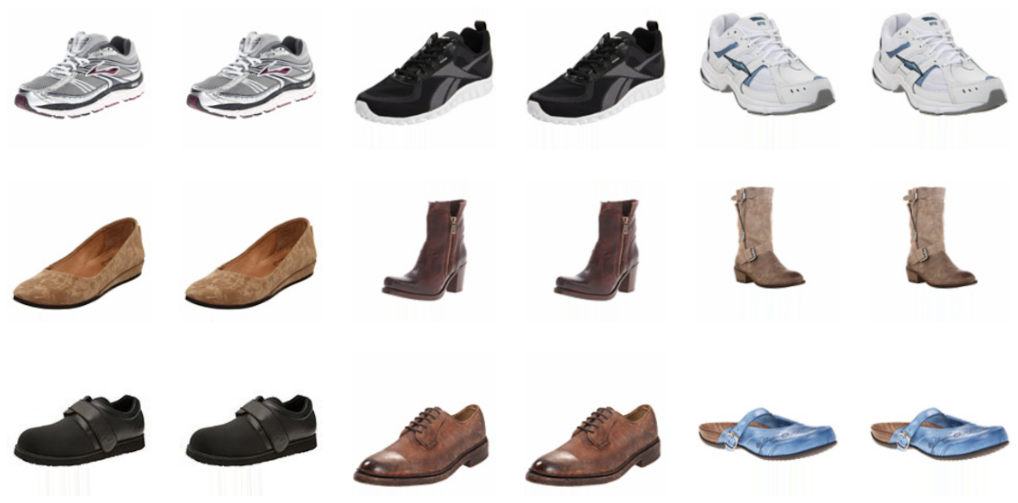

In [ ]:
dls.show_batch()

In [ ]:
# # lets grab a batch to have it handy for testing
# x,y = dls.one_batch()
# x.shape, y.shape

## creating the VAE

Variational Auto-Encoder for fastai

I'm going to use a generic convolutional net as the basis of the encoder, and its reverse as the decoder. This is a proof of concept for using the _fastai_ framework, and will experiment with pre-trained resnet and MobileNet_v2 later. I'd like to use the MobileNet_v2 as a direct link ot the "SneakerFinder" tool which motivated this experiment. [see SneakerFinder]

A variational "module" will sit between the encoder and decoder as the "Bottleneck". The Bottleneck will map the resnet features into a latent space (e.g. ~100 dimensions) represented of standard normal variables.  The "reparameterizatoin trick" will sample from this space and the "decoder" will generate images. 

Finally a simple "decoder" will sample from the variational latents space and be trained to reconstruct the images. 

The intention is the latent space can be used to generate novel sneaker images.



### constructing VAE with Module Class Layers

For several of the decoder and "sampler" layers I might want to turn off the nonlinearity to give us more reasonable "gaussian" outputs to the Variational layer and the generated image which will is compared with the ImageNetStats batch-normalized image.

In [ ]:
# this is the "Variational" magic.  aka the "reparamaterization trick"
class NormalSampler(Module):
    #def __init__(self):
    #super(NormalSampler,self).__init__()#not needed for Module vs nn.Module
    def forward(self,mu,logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
        ## alternative sampling code...
            #     def reparameterize(self, mu, logvar):
            #         std = logvar.mul(0.5).exp_()
            #         esp = torch.cuda.HalfTensor(*mu.size()).normal_()
            #         z = mu + std * esp
            #         return z
        #         if self.training:
        #             std = logvar.mul(0.5).exp_()
        #             eps = Variable(std.data.new(std.size()).normal_())
        #             return eps.mul(std).add_(mu)
        #         else:
        #             return mu
    
    
class VAELinear(Module):
    def __init__(self,in_features,out_features):
        #super(VAELinear,self).__init__()#not needed for Module vs nn.Module
        #self.linear = nn.Linear(in_features,out_features)
        # don't include relu? remove with act=None
        self.fc_in = LinBnDrop(in_features,out_features,bn=False,p=0.0,act=None,lin_first=False)
        self.mu_linear = nn.Linear(out_features,out_features)
        self.logvar_linear = nn.Linear(out_features,out_features)

    def forward(self,x):
        h = self.fc_in(x)
        mu = self.mu_linear(h)
        logvar = self.logvar_linear(h)
        return mu,logvar

    
class VAELayer(Module):
    def __init__(self,in_features,out_features):
        #super(VAELayer,self).__init__()#not needed for Module vs nn.Module
        self.mu_logvar = VAELinear(in_features,out_features)
        self.sampler = NormalSampler()

    def forward(self,x):
        mu,logvar = self.mu_logvar(x)
        logvar = F.softplus(logvar)   # force logvar>0
        z = self.sampler(mu,logvar)
        return z, mu, logvar
    
                
    
class VAEBottleneck(Module):
    """    
    Wrapper to make the VAELayer play nice with the input (from encoder)
    and output (to decoder/generator) via fc layers.
    """
    def __init__(self,input_dim,fc_dim,latent_dim,bn=True,drop_p=0.0,act=nn.ReLU()):
        self.bn = nn.Sequential(LinBnDrop(input_dim,2*fc_dim,bn=bn,p=drop_p,act=act,lin_first=False),
                                LinBnDrop(2*fc_dim,fc_dim,bn=False),
                        VAELayer(in_features=fc_dim, out_features=latent_dim))
    
    def forward(self,x):

        # maybe assert that the shape is bs,encoder_features?
        z,mu,logvar = self.bn(x)
        return z, mu, logvar

In [ ]:
class CVAEDecoder(Module):
    def __init__(self,latent_dim,im_size,out_range):
        # Sampling vector
        self.latent_dim = latent_dim
        self.im_size = im_size
        self.out_range = out_range

        # Decoder
        #         self.decoder 
        #first_layer = ConvLayer(nfs[0],nfs[1],ks=ks[0],stride=1,padding=0,bias = True)
        # [first_layer] +
        nfs = [3, 32, 64, 128,256,512]        
        self.sampling = nn.Sequential(LinBnDrop(self.latent_dim,nfs[-1]*5*5,
                                                bn=False),
                                      ResizeBatch(nfs[-1],5,5))        
             

        nfs.reverse()
        n = len(nfs)
 
        # default activation and batchnorm?
        modules =  [ConvLayer(nfs[i],nfs[i+1],
                                 ks=3,
                                 stride=2,
                                 padding=1,
                                 transpose=True,
                                 output_padding=1) for i in range(n - 1)]        
        
        self.decoder = nn.Sequential(*modules,
                                     ConvLayer(nfs[-1],
                                               nfs[-1],
                                                 ks=3,
                                                 stride=2,
                                                 padding=1,
                                                 transpose=True,
                                                 output_padding=1),
                                     ConvLayer(nfs[-1],
                                               nfs[-1],
                                                 ks=3, stride=2,
                                                 padding=1,#act_cls=nn.Tanh))
                                                 act_cls=partial(SigmoidRange, *self.out_range)) )

                                      
    def forward(self,z):
        h = self.sampling(z)
        x_hat = self.decoder(h)
        return x_hat
  
  
    
class CVAEEncoder(Module):
    def __init__(self):

        
           #         self.decoder 
        #first_layer = ConvLayer(nfs[0],nfs[1],ks=ks[0],stride=1,padding=0,bias = True)
        # [first_layer] +
        nfs = [3, 32, 64, 128, 256, 512]
        
        n = len(nfs)
        
        # default activation and batchnorm?
        modules =  [ConvLayer(nfs[i],nfs[i+1],
                                 ks=3,
                                 stride=2, # transpose=False, output_padding=1
                                 padding=1) for i in range(n - 1)]        
        
        
        self.encoder = nn.Sequential(*modules,
                                    Flatten()) #,nn.Tanh())
        
    def forward(self,x):
        return self.encoder(x)

### simple VAE class from VAE layer class components

once we have this we can do three things:

    1. develop proper VAE loss functions (including KL Divergence constraint on latent variables)
    2. create callbacks (and custom learner?) for training
    3. extend to a beta-variational framework with aims at creating "disentangled" latent dimensions
    

In [ ]:

class CVAE(Module):
    def __init__(self, latent_dim=128,im_size=IMG_SIZE,out_range=[-3,3]):
        fc_dim = 512*5*5
        store_attr('fc_dim,latent_dim,im_size')

        # encoder
        self.enc = CVAEEncoder()

        # bottleneck
        self.v_layer = VAELayer(in_features=self.fc_dim, out_features=self.latent_dim)
        # decoder

        #self.dec = VAEDecoder(latent_dim,self.fc_dim,self.out_dim,self.im_size,self.out_range,self.drop_p)
        self.dec = CVAEDecoder(self.latent_dim,self.im_size,out_range)

    def forward(self,x):
        h = self.enc(x)
        y, mu, logvar = self.v_layer(h)
        x_hat = self.dec(y)
        return x_hat, mu, logvar

cvae = CVAE()

Sweet, we've verified the arcitecture works, but we need to train it with a loss that constrains the variational layers with the KL Divergence.  Otherwise the simple MSE will diverge.  

## VAE Loss functions classes

We have acouple examples to follow:  

    1. TabularData Vae (fastai v2 patterning) (@EtienneT)
    2. pure PyTorch Vae which is directly related to our image dataset  (@AntixK)

In [ ]:
class VAELoss(Module):
    """
    Measures how well we have created the original image, 
    plus the KL Divergence with the unit normal distribution
    """
    def __init__(self, im_size, latent_dim,beta=None):
        #ce = CrossEntropyLossFlat(reduction='sum')
        mse = MSELossFlat(reduction='sum')
        if beta is None:
            # intitalize so that we start beta balancing the two losses
            beta = im_size*im_size/latent_dim
        store_attr('mse,im_size,latent_dim,beta')
        
    def forward(self, preds, target):
        """
        pred =(x_hat,mu,log_var, kl_weight)
        x_target is x (original) 
        """
        # this handles the annealed kl_weight we added...
        if(len(preds) == 4):
            x_hat, mu, logvar, kl_weight = preds
        else:
            x_hat, mu, logvar = preds
            kl_weight = 1
        
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        total = self.mse(x_hat, target) 
        KLD *= self.beta
        
        # This factor depends on your batch size and the size of the dataset.  A good rule of thumb is df.shape[0] / batch_size
        # if we don't have this, the KLD loss might become much larger than the reconstruction loss
        
        return (total + (kl_weight * KLD))
        


In [ ]:
#loss_func = VAELoss(IMG_SIZE, latent_dim)


In [ ]:
class MSEMetric(Metric):
    def __init__(self): self.preds = []
    def accumulate(self, learn):
        x_hat, mu, logvar = learn.pred
        x_targs = learn.y

        self.preds.append( to_detach( F.mse_loss(x_hat, x_targs, reduction='sum') ) )
    @property
    def value(self):
        return np.array(self.preds).mean()
    
class KLDMetric(Metric):
    def __init__(self): self.preds = []
    def accumulate(self, learn):
        x_hat, mu, logvar = learn.pred
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        self.preds.append(to_detach(KLD))
    @property
    def value(self):
        return np.array(self.preds).mean()
    
class MuMetric(Metric):
    def __init__(self): self.preds = []
    def accumulate(self, learn):
        x_hat, mu, logvar = learn.pred
        self.preds.append(to_detach(mu.mean()))
    @property
    def value(self):
        return np.array(self.preds).mean()
    
        
class MuSDMetric(Metric):
    def __init__(self): self.preds = []
    def accumulate(self, learn):
        x_hat, mu, logvar = learn.pred
        self.preds.append(to_detach(mu.std()))
    @property
    def value(self):
        return np.array(self.preds).mean()
    
    
class StdMetric(Metric):
    def __init__(self): self.preds = []
    def accumulate(self, learn):
        x_hat, mu, logvar = learn.pred
        self.preds.append(to_detach((logvar.exp_() ** .5).mean()))
    @property
    def value(self):
        return np.array(self.preds).mean()
    
class StdSDMetric(Metric):
    def __init__(self): self.preds = []
    def accumulate(self, learn):
        x_hat, mu, logvar = learn.pred
        self.preds.append(to_detach((logvar.exp_() ** .5).std()))
    @property
    def value(self):
        return np.array(self.preds).mean()
    


AnnealedLossCallback will inject the variable kl_weight in our loss. You can see the schedule graph of the parameter. At the beginning it will be 0, thus the KLD part of the loss will get ignored. So during 10% of training, we will fit a normal auto-encoder. Then gradually for 30% of trainning, increase kl_weight to 1 and then remain there for the remaining training time so that the auto encoder now becomes full variational. The way this callback is done, the loss will receive this parameter, but not the model.

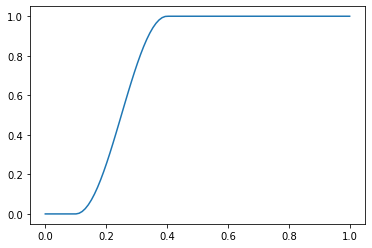

In [ ]:

class AnnealedLossCallback(Callback):
    def after_pred(self):
        kl = self.learn.pred[0].new(1)
        kl[0] = self.opt.hypers[0]['kl_weight']
        self.learn.pred = self.learn.pred + (kl,)
    def after_batch(self):
        if(len(self.learn.pred)):
            x_hat, mu, logvar, _ = self.learn.pred
        else:
            x_hat, mu, logvar = self.learn.pred
            
        self.learn.pred = (x_hat, mu, logvar)
        
f = combine_scheds([.1, .3, .6], [SchedCos(0,0), SchedCos(0,1), SchedNo(1,1)])
p = torch.linspace(0.,1,100)
plt.plot(p,[f(o) for o in p])


We'll make an config dictionary for us to use as a list of all hyper parameters. Also we avoid using early stopping because the AnnealedLossCallback will make the loss grow once the KL divergence weight kicks in.


In [ ]:
# this might become convenient....
config = {
    'latent_dim': 128,
    'dropout': 0.1,
    'wd': None, #0.01,
    'lr': 1e-3,
    'epochs': 100,
    'im_size': IMG_SIZE,
    'beta':200
}

beta = config['im_size']**2/ config['latent_dim']
config['beta']=beta

cbs = [ParamScheduler({'kl_weight': f }), AnnealedLossCallback(),TerminateOnNaNCallback()]
metrics = [MSEMetric(), KLDMetric(), MuMetric(), StdMetric()]



In [ ]:
# make model and learner


class VAELearner(Learner):
    """
    use this to overload hacks to deal with passing the mu, std around...
    """        
    def __init__(self,data:DataLoaders,ae:Module,loss_func=None,im_size=IMG_SIZE,latent_dim=128,beta=None,**kwargs):
        
        if loss_func is None:
            loss_func = VAELoss(im_size, latent_dim,beta)
        
        store_attr('im_size,latent_dim,beta')
        
        super().__init__(dls, ae, loss_func=loss_func, **kwargs)
        # TODO:  this is probably more ifficient than having x,y as ImageBlocks
        #         # Callback to replace y with x during the training loop
        #         replace_cb = ReplaceTargetCallback(self)
        #         self.callbacks.append(replace_cb)

    def show_results(self, ds_idx=1, dl=None, max_n=9, shuffle=True, **kwargs):
            if dl is None: dl = self.dls[ds_idx].new(shuffle=shuffle)
            b = dl.one_batch()
            _,_,preds = self.get_preds(dl=[b], with_decoded=True)
            # strip off the mu and logvar from preds... maybe I can add a "predict" function to the class?
            out = preds[0]
            self.dls.show_results(b, out, max_n=max_n, **kwargs)


            

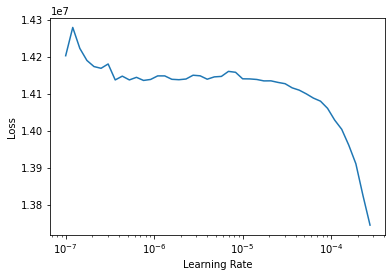

In [ ]:
latent_dim = 128
learn = VAELearner(dls, cvae, im_size=IMG_SIZE, latent_dim=latent_dim, 
                          cbs=cbs, metrics=metrics) #wd=config['wd'],opt_func=ranger,

lr1,lr2=learn.lr_find()

In [ ]:
lr = .5*(lr1+lr2)
glr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

config['lr']=lr

lr1,lr2,lr,glr



(2.7542287716642023e-05,
 0.00019054606673307717,
 0.00010904417722485959,
 7.244358130265027e-05)

In [ ]:
#learn.fit_flat_cos(config['epochs'], lr=4e-7)
learn.fit_one_cycle(5, lr_max=lr)

epoch,train_loss,valid_loss,mse,kld,mu,std,time
0,6714953.500000,13571801.000000,13258113.000000,5811.950684,-0.056707,1.026340,00:54
1,5741220.000000,11394831.000000,12039412.000000,4286.953125,-0.033881,1.013434,00:54
2,5072277.500000,10303190.000000,11283207.000000,3712.842041,-0.031813,1.008979,00:54
3,4703362.000000,9135754.000000,10621858.000000,3385.600586,-0.026917,1.006738,00:54
4,4703374.500000,9491315.000000,10293208.000000,3203.459229,-0.024415,1.005392,00:54


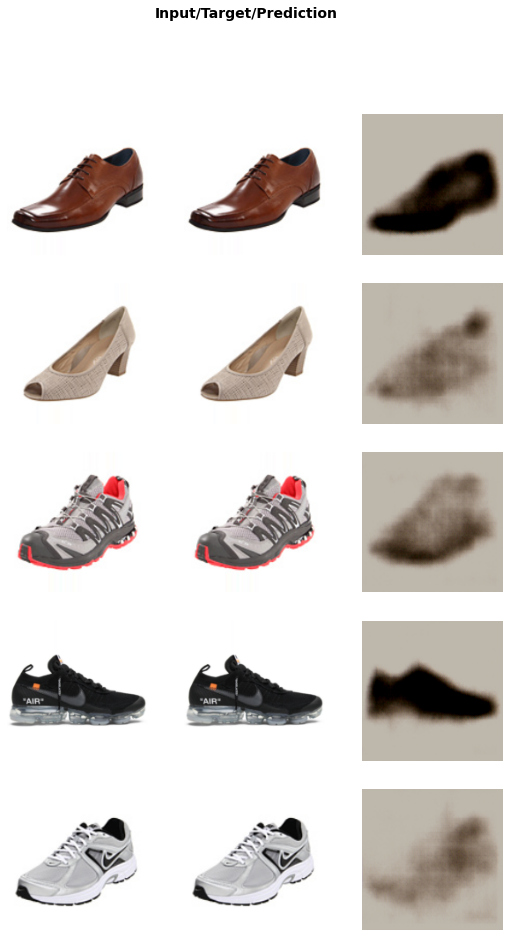

In [ ]:
learn.show_results()

(1.4454397387453355e-06,
 1.3182567499825382e-06,
 1.3818482443639367e-06,
 1.3803839920001337e-06)

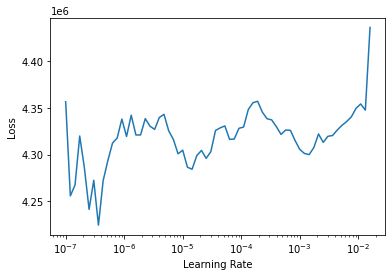

In [ ]:

lr1,lr2=learn.lr_find()
lr = .5*(lr1+lr2)
glr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,lr,glr




In [ ]:
learn.fit_one_cycle(50, lr_max=lr)
learn.show_results()

epoch,train_loss,valid_loss,mse,kld,mu,std,time
0,4433983.000000,8816574.000000,10043277.000000,3089.836182,-0.022296,1.004491,00:54
1,4417773.000000,8859820.000000,9871909.000000,3037.216309,-0.020699,1.003852,00:54
2,4370851.000000,8669103.000000,9719613.000000,3032.963867,-0.019429,1.003372,00:54
3,4361792.000000,8730583.000000,9607933.000000,3076.654785,-0.018204,1.002999,00:54
4,4354220.500000,8655546.000000,9511067.000000,3174.481445,-0.017179,1.002700,00:54
5,4308552.000000,8807235.000000,9444623.000000,3321.371094,-0.016385,1.002456,00:54
6,4325728.000000,8690189.000000,9376466.000000,3502.627930,-0.015949,1.002252,00:54
7,4334411.500000,8713501.000000,9315635.000000,3683.163330,-0.015899,1.002080,00:54
8,4342892.000000,8789881.000000,9263121.000000,3837.257324,-0.016084,1.001933,00:54
9,4420603.000000,8897217.000000,9219047.000000,3953.212646,-0.016405,1.001805,00:54


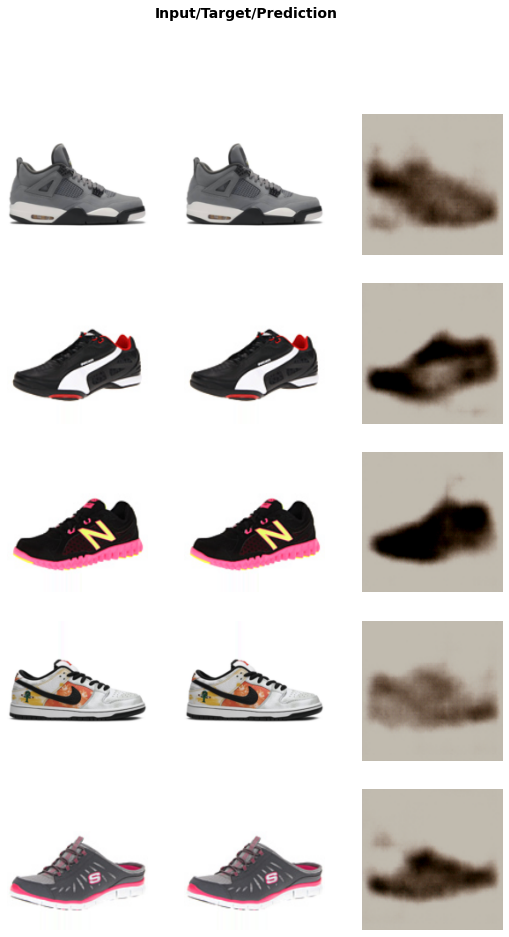

In [ ]:
learn.show_results()

(7.585775847473997e-08,
 6.309573450380412e-07,
 3.534075517563906e-07,
 2.1877620781651785e-07)

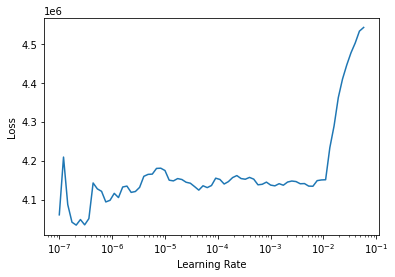

In [ ]:

lr1,lr2=learn.lr_find()
lr = .5*(lr1+lr2)
glr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,lr,glr


epoch,train_loss,valid_loss,mse,kld,mu,std,time
0,4173057.750000,8328775.500000,8646967.000000,3045.701904,-0.014793,1.000485,00:54
1,4161260.000000,8470788.000000,8643590.000000,3042.165527,-0.014754,1.000476,00:55
2,4127360.000000,8319143.000000,8637606.000000,3045.725098,-0.014702,1.000468,00:54
3,4099473.000000,8189621.500000,8628546.000000,3057.388916,-0.014636,1.000460,00:55
4,4184812.500000,8326909.500000,8619860.000000,3074.330078,-0.014648,1.000453,00:54
5,4262650.500000,8669085.000000,8614452.000000,3090.365234,-0.014720,1.000445,00:54
6,4324058.500000,8646599.000000,8607210.000000,3097.839600,-0.014746,1.000438,00:54
7,4375950.500000,8880429.000000,8602701.000000,3100.064453,-0.014793,1.000431,00:54
8,4439484.000000,8921734.000000,8598648.000000,3097.490234,-0.014811,1.000424,00:55
9,4405481.500000,8735622.000000,8592083.000000,3091.938721,-0.014816,1.000418,00:54


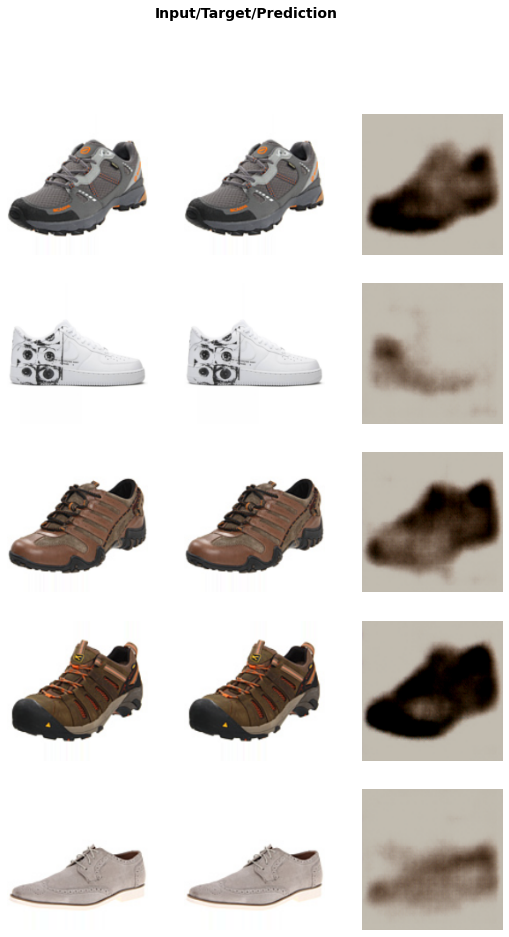

In [ ]:
learn.fit_one_cycle(25, lr_max=lr2)
learn.show_results()

(0.0006309573538601399,
 1.0964781722577754e-06,
 0.00031602691601619883,
 2.6302690457669087e-05)

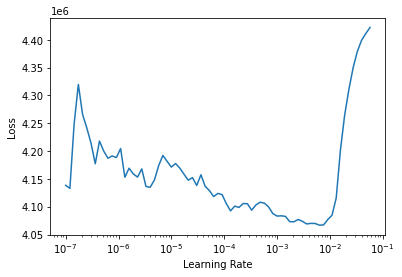

In [ ]:

lr1,lr2=learn.lr_find()
lr = .5*(lr1+lr2)
glr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,lr,glr


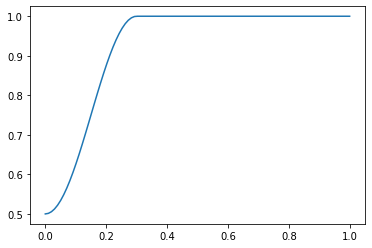

In [ ]:
f = combine_scheds([.3, .7], [SchedCos(0.5,1), SchedNo(1,1)])
p = torch.linspace(0.,1,100)
plt.plot(p,[f(o) for o in p])


epoch,train_loss,valid_loss,mse,kld,mu,std,time
0,3856992.000000,7554475.500000,8522440.000000,3097.959961,-0.014615,1.000335,00:54
1,3612052.250000,6935955.500000,8501377.000000,3320.628418,-0.014640,1.000331,00:55
2,3456788.000000,6864017.000000,8477535.000000,3360.010742,-0.014616,1.000327,00:54
3,3158938.500000,6579448.000000,8449135.000000,3368.223877,-0.014684,1.000324,00:55
4,2853355.000000,5554616.000000,8408723.000000,3363.960449,-0.014711,1.000321,00:55
5,2543635.000000,5230463.000000,8365025.500000,3358.025635,-0.014705,1.000318,00:55
6,2250163.750000,4276886.500000,8312031.000000,3349.068359,-0.014831,1.000315,00:55
7,2043764.000000,3879703.500000,8255544.000000,3341.280273,-0.014994,1.000312,00:54
8,1895247.125000,3893646.250000,8200447.500000,3333.820068,-0.015074,1.000309,00:55
9,1773628.250000,3523118.750000,8142656.500000,3325.598145,-0.015204,1.000306,00:55


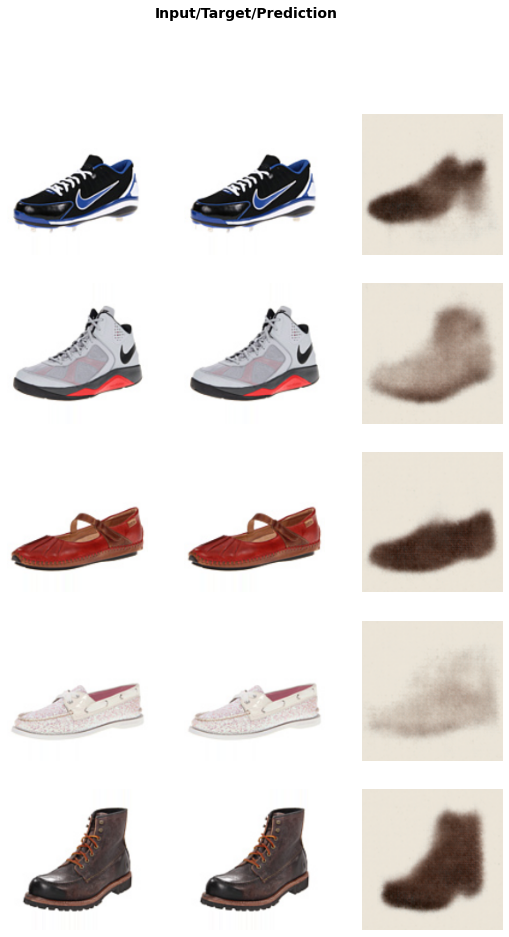

In [ ]:
learn.fit_one_cycle(15, lr_max=.0001)
learn.show_results()

In [ ]:
# pretty sure this is failing because the network returns more than just the generated image...
# maybe I can overload the output block so 
b = learn.dls.one_batch()
x,y,its = learn.dls.show_batch(b, max_n=9, show=False)

In [ ]:
_,_,preds = learn.get_preds(dl=[b], with_decoded=True)

In [ ]:
x_hat = preds[0][1].squeeze()
x_ = b[0].squeeze()
x_.max(),x_hat.max()

(TensorImage(2.6400, device='cuda:0'), tensor(0.5971))

In [ ]:

learn = VAELearner(dls, resnet_vae, im_size=IMG_SIZE, latent_dim=latent_dim, 
                          cbs=cbs, metrics=metrics) #wd=config['wd'],opt_func=ranger,

lr1,lr2=learn.lr_find()

NameError: name 'resnet_vae' is not defined

In [ ]:
lr = .5*(lr1+lr2)
glr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

config['lr']=lr

lr1,lr2,lr,glr



In [ ]:
#learn.fit_flat_cos(config['epochs'], lr=4e-7)
learn.fit_one_cycle(50, lr_max=lr1)

35023

In [ ]:
learn.fit_flat_cos(config['epochs'], lr=4e-7)


In [ ]:
# preds = resnet_vae.cuda()(x)
# x_hat,mu,logvar = preds
# loss_func(preds,x)
type(learn.dls)

fastai.data.core.DataLoaders

In [ ]:
def autoencoder_show_results(): pass


def learner.show_results(self, ds_idx=1, dl=None, max_n=9, shuffle=True, **kwargs):
        if dl is None: dl = self.dls[ds_idx].new(shuffle=shuffle)
        b = dl.one_batch()
        _,_,preds = self.get_preds(dl=[b], with_decoded=True)
        self.dls.show_results(b, preds, max_n=max_n, **kwargs)
        
        
#TfmdDL        
def show_results(self, b, out, max_n=9, ctxs=None, show=True, **kwargs):
        x,y,its = self.show_batch(b, max_n=max_n, show=False)
        b_out = type(b)(b[:self.n_inp] + (tuple(out) if is_listy(out) else (out,)))
        x1,y1,outs = self.show_batch(b_out, max_n=max_n, show=False)
        res = (x,x1,None,None) if its is None else (x, y, its, outs.itemgot(slice(self.n_inp,None)))
        if not show: return res
        show_results(*res, ctxs=ctxs, max_n=max_n, **kwargs)

def ae_show_results(x:TensorImage, y:TensorImage, samples, outs, ctxs=None, max_n=10, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(3*min(len(samples), max_n), ncols=3, figsize=figsize, title='Input/Target/Prediction')
    for i in range(2):
        ctxs[i::3] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i),ctxs[i::3],range(max_n))]
    ctxs[2::3] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(outs.itemgot(0),ctxs[2::3],range(max_n))]
    return ctxs



In [ ]:
doc(dls.show_results)

In [ ]:
learn.loss_func.beta

200.0

In [ ]:
out = pred
b_out = type(b)(b[:learn.dls.n_inp] + (tuple(out) if is_listy(out) else (out,)))
len(out)

3

In [ ]:
b[2].shape

IndexError: tuple index out of range

In [ ]:
h = learn.model.enc(b[0])
h.shape[0]//160
learn.model.enc.resnet(b[0])


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
z,mu,logvar=learn.model.bottleneck(h)
z.shape

torch.Size([32, 128])

In [ ]:
x_hat0 = learn.model.dec(z)

x_hat = learn.model(b[0])
x_hat_,mu_,logvar_ = x_hat

beta = IMG_SIZE*IMG_SIZE/latent_dim
KLD_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
mse_loss = loss_func.mse(x_hat[0], b[0])
KLD_loss,mse_loss,x_hat[1].mean(),x_hat[2].mean(),KLD_loss*beta

type(MulBackward0)

NameError: name 'MulBackward0' is not defined

In [ ]:
learn.recorder.plot_loss()

NameError: name 'learn' is not defined

# TODO  Feb1

We might need to add a second FC layer before the convt ladder... right now its just direct.

open questions:
batch normalization on FC layers?  on conv layers?

beta-vae loss?

how should we weight the MSE over 3*160*160 against KLD for 128 features?

###

TypeError: cannot unpack non-iterable NoneType object

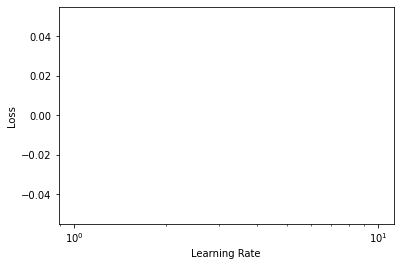

In [ ]:
lr1,lr2=learn.lr_find()


lr1,lr2

In [ ]:
config['lr']=.0005
config['epochs']=100
learn = Learner(dls, resnet_vae, lr=config['lr'], loss_func=loss_func, 
                        wd=config['wd'], opt_func=ranger, cbs=cbs, metrics=metrics)

learn.fit_flat_cos(config['epochs'], lr=config['lr'])

learn.show_results()
learn.recorder.plot_loss()

In [ ]:
b = learn.dls.one_batch()

epoch,train_loss,valid_loss,mse,kld,mu,std,mu_sd,std_sd,time


RuntimeError: running_mean should contain 12800 elements not 2560

In [ ]:
b[0]

TensorImage([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  .

In [ ]:
_,_,preds = learn.get_preds(dl=[b], with_decoded=True)

In [ ]:
x,y,its = learn.dls.show_batch(b, max_n=9, show=False)
b_out = type(b)(b[:learn.dls.n_inp] + (tuple(preds) if is_listy(preds) else (preds,)))


In [ ]:
#learn.predict(x)
#doc(Learner.predict)
https://docs.fast.ai/learner#Learner.predict

SyntaxError: invalid syntax (<ipython-input-64-49cdbe72b7df>, line 3)

TypeError: cannot unpack non-iterable NoneType object

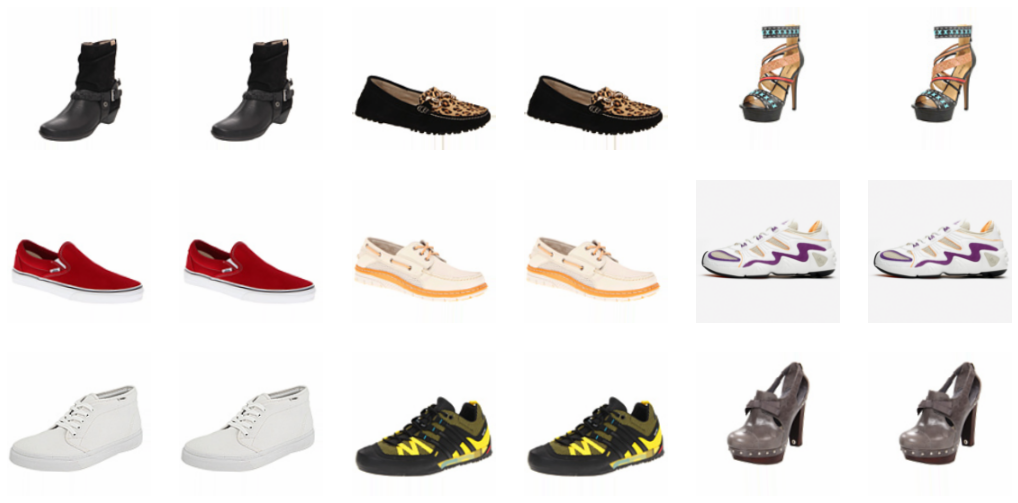

In [ ]:
x,y,its = learn.dls.show_batch()

# lets grab a batch to have it handy for testing
x,y = dls.one_batch()
x.shape, y.shape

In [ ]:
learn.fit_flat_cos(config['epochs'], lr=config['lr'])

epoch,train_loss,valid_loss,mse,kld,mu,std,time
0,22954.603516,45545.718750,9183103.000000,204629.562500,-0.113731,1.200715,01:10
1,22910.300781,45464.878906,9161653.000000,221023.046875,-0.128437,1.184159,01:10
2,22934.806641,45449.050781,9146824.000000,234256.406250,-0.139910,1.176970,01:11


### pure PyTorch
@AntixK


https://github.com/AntixK/PyTorch-VAE/blob/master/models/beta_vae.py

#### Disentangled BB-VAE 
https://openreview.net/forum?id=Sy2fzU9gl

 25 lines (22 sloc) 425 Bytes
model_params:
  name: 'BetaVAE'
  in_channels: 3
  latent_dim: 128
  loss_type: 'H'
  beta: 10.

exp_params:
  dataset: celeba
  data_path: "../../shared/Data/"
  img_size: 64
  batch_size: 144 # Better to have a square number
  LR: 0.0005
  weight_decay: 0.0
  scheduler_gamma: 0.95
  
  
```python

# BETA-VAE
def loss_function(self,
                  *args,
                  **kwargs) -> dict:
    self.num_iter += 1
    recons = args[0]
    input = args[1]
    mu = args[2]
    log_var = args[3]
    kld_weight = kwargs['M_N']  # Account for the minibatch samples from the dataset

    recons_loss =F.mse_loss(recons, input)

    kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

    loss = recons_loss + self.beta * kld_weight * kld_loss
    
    return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':kld_loss}
```



#### Beta-VAE
https://arxiv.org/pdf/1804.03599.pdf


model_params:
  name: 'BetaVAE'
  in_channels: 3
  latent_dim: 128
  loss_type: 'B'
  gamma: 10.0
  max_capacity: 25
  Capacity_max_iter: 10000

exp_params:
  dataset: celeba
  data_path: "../../shared/Data/"
  img_size: 64
  batch_size: 144 # Better to have a square number
  LR: 0.0005
  weight_decay: 0.0
  scheduler_gamma: 0.95



```python

# Disentangled VAE (BETAVAE)
def loss_function(recons,input,mu,log_var,kld_weight) -> dict:
    # SAME BUT WITH BETA=25 LINEARLY ANNEALED KLD IN 1E5 ITERATIONS...
    max_capacity = 25
    Capacity_max_iter = 1e5

    self.latent_dim = latent_dim
    self.beta = beta
    self.gamma = gamma
    self.loss_type = loss_type
    self.C_max = torch.Tensor([max_capacity])
    self.C_stop_iter = Capacity_max_iter

    self.num_iter += 1
    #kld_weight = kwargs['M_N']  # Account for the minibatch samples from the dataset

    recons_loss =F.mse_loss(recons, input)

    kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

    self.C_max = self.C_max.to(input.device)
    C = torch.clamp(self.C_max/self.C_stop_iter * self.num_iter, 0, self.C_max.data[0])
    loss = recons_loss + self.gamma * kld_weight* (kld_loss - C).abs()
    

    return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':kld_loss}
 ```


In [ ]:
class AutoEncoderLearner(Learner):
    def __init__(self,data:DataBlock,rec_loss:str,enc:nn.Module,bn:nn.Module,dec:nn.Module,**kwargs):
        self.enc = enc
        self.bn = bn
        self.dec = dec
        
        assert rec_loss in ["mse","ce"],"Loss function must be mse or ce"
        if rec_loss == "mse":
            self.rec_loss = nn.MSELoss(reduction="none")
        else:
            self.rec_loss = nn.CrossEntropyLoss(reduction="none")
        self.encode = nn.Sequential(enc,bn)
        
        self.inferring = False
        
        ae = nn.Sequential(enc,bn,dec)
        
        super().__init__(data, ae, loss_func=self.loss_func, **kwargs)
        
        # Callback to replace y with x during the training loop
        replace_cb = ReplaceTargetCallback(self)
        self.callbacks.append(replace_cb)
        
    def loss_func(self,x_rec,x,**kwargs):
        bs = x.shape[0]
        if isinstance(self.rec_loss,nn.MSELoss):
            l = self.rec_loss(x, x_rec).view(bs, -1).sum(dim=-1).mean()
        else:
            # First we discretize x and turn it from (B,1,H,W) to (B,H,W)
            x = (x * 256).long().squeeze(1)
            l = self.rec_loss(x_rec,x).view(bs,-1).sum(dim=-1).mean()
        return l
    
    def decode(self,z):
        x_rec = self.dec(z)
        return x_rec
    
#     def plot_2d_latents(self,ds_type:DatasetType=DatasetType.Valid, n_batch = 10,return_fig=False):
#         """Plot a 2D map of latents colored by class"""
#         z,y = self.get_latents(ds_type = ds_type, n_batch = n_batch)
#         z,y = z.numpy(), y.numpy()
#         print("Computing the TSNE projection")
#         zs = TSNE(n_components=2).fit_transform(z)
#         fig,ax = plt.subplots(1,figsize = (16,12))
#         ax.scatter(zs[:,0],zs[:,1],c = y)
#         ax.set_title("TSNE projection of latents on two dimensions")
#         if return_fig:
#             return fig
        
    def plot_rec(self,x=None,i=0,sz = 64,gray = True):
        """Plot a """
        self.model.cpu()
        if not isinstance(x,torch.Tensor):
            x,y = self.data.one_batch()
            
        x_rec = self.model(x)
        
        if isinstance(self.rec_loss,nn.CrossEntropyLoss):
            x_rec = x_rec.argmax(dim = 1,keepdim = True)
            
        x_rec = x_rec[i].squeeze(1)
        x = x[i].squeeze(1)

        img = x.permute(1,2,0).numpy()
        img_r = x_rec.permute(1,2,0).detach().numpy()
        
        if gray:
            img = np.concatenate((img,)*3,axis = -1)
            img_r = np.concatenate((img_r,)*3,axis = -1)

        fig,ax = plt.subplots(2,figsize = (16,16))
        ax[0].imshow(img,cmap = "gray")
        ax[0].set_title("Original")

        ax[1].imshow(img_r,cmap = "gray")
        ax[1].set_title("Reconstruction")

        self.model.cuda()

    # We perturb the latent variables on each variable with different magnitudes 
    def plot_shades(self,x=None,i=0,n_perturb = 13, mag_perturb = 3, ax = None):
        """Plot the reconstruction of the """
        self.model.cpu()
        if not isinstance(x,torch.Tensor):
            x,y = self.data.one_batch()

        x = x[i].unsqueeze(0)

        # We get the latent code
        z = self.encode(x)
        n_z = z.shape[1]

        # We create a scale of perturbations
        mag_perturb = np.abs(mag_perturb)
        scale_perturb = np.linspace(-mag_perturb,mag_perturb,n_perturb)
        
        if not ax:
            fig, ax = plt.subplots(n_z,n_perturb, figsize=(16,12))
            fig.tight_layout()

        for i in range(n_z):
            for (j,perturb) in enumerate(scale_perturb):
                # For each z_i we add a minor perturbation
                z_perturb = z.clone()
                z_perturb[0,i] += perturb

                # We reconstruct our image
                x_rec = self.decode(z_perturb)

                # We plot it in the grid
                img = x_rec.squeeze(0).permute(1,2,0).detach().numpy()
                ax[i][j].set_axis_off()
                ax[i][j].imshow(img)
                ax[i][j].set_title(f"z_{i} with {round(perturb * 1e2) / 1e2}")
                
        self.model.cuda()
        
    def get_latents(self, ds_type:DatasetType=DatasetType.Valid, activ:nn.Module=None,
                  with_loss:bool=False, n_batch=None, pbar=None):
        "Return predictions and targets on `ds_type` dataset."
        lf = self.loss_func if with_loss else None
        self.inferring = True
        output = get_preds(self.encode, self.dl(ds_type), cb_handler=CallbackHandler(self.callbacks),
                         activ=activ, loss_func=lf, n_batch=n_batch, pbar=pbar)
        self.inferring = False
        return output
    
    def get_error(self, ds_type:DatasetType=DatasetType.Valid,activ:nn.Module=None, n_batch=None, pbar=None):
        "Return predictions and targets on `ds_type` dataset."
        
        x_rec,x = get_preds(self.model, self.dl(ds_type), cb_handler=CallbackHandler(self.callbacks),
                         activ=activ, loss_func=None, n_batch=n_batch, pbar=pbar)
        loss_func = lambda x_rec,x : self.rec_loss(x, x_rec, reduction='none').view(x.shape[0], -1).sum(dim=-1)
        l = loss_func(x_rec,x)
        return l
    
    
def gray_to_rgb(img):
    return np.concatenate((img,)*3,axis=-1)

def register_output(m,i,o):
    return o

class VisionAELearner(AutoEncoderLearner):
    def plot_rec(self,x=None,random=False,n=5,gray = True,return_fig=False):
        """Plot a """
        self.model.cpu()
        if not isinstance(x,torch.Tensor):
            x,y = self.data.one_batch()
        
        bs = self.data.batch_size
        
        assert n < bs, f"Number of images to plot larger than batch size {n}>{bs}"
        
        if random:
            idx = np.random.choice(bs,n,replace = False)
        else:
            idx = np.arange(n)
        x = x[idx]
        
        x_rec = self.model(x)
    
        if isinstance(self.rec_loss,nn.CrossEntropyLoss):
            x_rec = x_rec.argmax(dim = 1,keepdim = True)
        
        fig,ax = plt.subplots(n,2,figsize = (20,20))
        
        for i in range(n):
            img = x[i].permute(1,2,0).numpy()
            img_r = x_rec[i].permute(1,2,0).detach().numpy()
    
            if gray:
                img = np.concatenate((img,)*3,axis = -1)
                img_r = np.concatenate((img_r,)*3,axis = -1)
                
            ax[i][0].imshow(img,cmap = "gray")
            ax[i][0].set_title("Original")
    
            ax[i][1].imshow(img_r,cmap = "gray")
            ax[i][1].set_title("Reconstruction")
        
        self.model.cuda()
        if return_fig:
            return fig
        
    def set_dec_modules(self,dec_modules:list):
        self.dec_modules = dec_modules

    def plot_rec_steps(self,x=None,random=False,n=5,gray = True,return_fig=False):
        """Plot a """
        self.model.cpu()
        if not isinstance(x,torch.Tensor):
            x,y = self.data.one_batch()
        
        bs = self.data.batch_size
        
        assert n < bs, f"Number of images to plot larger than batch size {n}>{bs}"
        
        if random:
            idx = np.random.choice(bs,n,replace = False)
        else:
            idx = np.arange(n)
        x = x[idx]
        
        modules = self.dec_modules
        
        with Hooks(modules,register_output) as hooks:
            x_rec = self.model(x)
            outputs = hooks.stored
            
            n_layers = len(outputs)
        
            fig,ax = plt.subplots(n,n_layers+1,figsize = (20,20))

            for i in range(n):
                img = x[i].permute(1,2,0).numpy()
                if gray : img = gray_to_rgb(img)
                
                ax[i][0].imshow(img,cmap = "gray")
                ax[i][0].set_title("Original")
                
                for j in range(n_layers):
                    img_r = outputs[j][i].mean(dim=0,keepdim=True).permute(1,2,0).detach().numpy()
                    if gray : img_r = gray_to_rgb(img_r)
                
                    ax[i][j+1].imshow(img_r,cmap = "gray")
                    ax[i][j+1].set_title(f"Step {j}")
            self.model.cuda()
            if return_fig:
                return fig




NameError: name 'DatasetType' is not defined

In [ ]:
#############
# mnist_vae.py

#import torch.nn as nn
#import torch
#from fastai_autoencoder.util import *
#from fastai_autoencoder.decoder import SpatialDecoder2D


#bottleneck.py
import torch.nn as nn
import torch
import torch.nn.functional as F

class NormalSampler(nn.Module):
    def __init__(self):
        super(NormalSampler,self).__init__()
    
    def forward(self,mu,logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

class VAELinear(nn.Module):
    def __init__(self,in_features,out_features):
        super(VAELinear,self).__init__()
        self.linear = nn.Linear(in_features,out_features)
        self.mu_linear = nn.Linear(out_features,out_features)
        self.logvar_linear = nn.Linear(out_features,out_features)

    def forward(self,x):
        x = self.linear(x)
        mu = self.mu_linear(x)
        logvar = self.logvar_linear(x)

        return mu,logvar

class VAELayer(nn.Module):
    def __init__(self,in_features,out_features):
        super(VAELayer,self).__init__()
        self.blinear = VAELinear(in_features,out_features)
        self.sampler = NormalSampler()

    def forward(self,x):
        mu,logvar = self.blinear(x)
        z = self.sampler(mu,logvar)
        return z

# class VQVAEBottleneck(nn.Module):
#     def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.25):
#         super(VQVAEBottleneck, self).__init__()
        
#         self._embedding_dim = embedding_dim
#         self._num_embeddings = num_embeddings
        
#         self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
#         self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
#         self._commitment_cost = commitment_cost

#         self.inferring = False
        
#     def forward(self, inputs):
#         # convert inputs from BxCxHxW to BxHxWxC

#         inputs = inputs.permute(0, 2, 3, 1).contiguous()
        
#         # Store the BxHxWxC shape
#         input_shape = inputs.shape
        
#         # Flatten input from BxHxWxC to BHWxC
#         flat_input = inputs.view(-1, self._embedding_dim)
        
#         # Calculate distances between our input BHWxC and the embeddings KxC which outputs a BHWxK matrix
#         distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
#                     + torch.sum(self._embedding.weight**2, dim=1)
#                     - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
#         # Computing the closest BHWxK to BHWx1
#         encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        
#         # If we are on inferrence mode we just output the discrete encoding in shape BxHxW
#         if self.inferring:
#             return encoding_indices.view(input_shape[:-1])
        
#         # We reshape from BHWxC to BxHxWxC
#         quantized = self._embedding(encoding_indices).view(input_shape)
        
#         # We compute the loss
#         e_latent_loss = torch.mean((quantized.detach() - inputs)**2)
#         q_latent_loss = torch.mean((quantized - inputs.detach())**2)
#         self.loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
#         # We switch the gradients
#         quantized = inputs + (quantized - inputs).detach()
        
#         # We permute from BxHxWxC to BxCxHxW
#         quantized = quantized.permute(0,3,1,2).contiguous()
        
#         return quantized

class VAEBottleneck(nn.Module):
    def __init__(self,nfs:list):
        super(VAEBottleneck,self).__init__()

        n = len(nfs)
        layers = [nn.Linear(in_features=nfs[i], out_features=nfs[i+1]) if i < n -2 
             else VAELayer(in_features=nfs[i], out_features=nfs[i+1]) for i in range(n-1)]
        # just makes a single VAELayer for nfs=[128,32]
        self.fc = nn.Sequential(*layers)
    
    def forward(self,x):
        bs = x.size(0)
        x = x.view(bs, -1)
        z = self.fc(x)
        
        return z

class Bottleneck(nn.Module):
    def __init__(self,nfs,activation):
        super(Bottleneck,self).__init__()

        n = len(nfs)
        layers = [nn.Linear(in_features=nfs[i], out_features=nfs[i+1]) for i in range(n-1)]

        self.fc = nn.Sequential(*layers)
    
    def forward(self,x):
        bs = x.size(0)
        x = x.view(bs, -1)
        z = self.fc(x)
        
        return z


    
######## callback.py
from fastai.callbacks import LearnerCallback
from fastai.basic_train import Learner
from fastai.callbacks.hooks import HookCallback
from fastai_autoencoder.bottleneck import VAELinear
import torch.nn as nn
import torch
import numpy as np

def get_layer(m,buffer,layer):
    """Function which takes a list and a model append the elements"""
    for c in m.children():
        if isinstance(c,layer):
            buffer.append(c)
        get_layer(c,buffer,layer)

class ReplaceTargetCallback(LearnerCallback):
    """Callback to modify the loss of the learner to compute the loss against x"""
    _order = 9999
    
    def __init__(self,learn:Learner):
        super().__init__(learn)
        
    def on_batch_begin(self,last_input,last_target,train,**kwargs):
        # We keep the original x to compute the reconstruction loss
        if not self.learn.inferring:
            return {"last_input" : last_input,"last_target" : last_input}
        else:
            return {"last_input" : last_input,"last_target" : last_target} 
        
# class VQVAEHook(HookCallback):
#     """Callback to modify the loss of the learner to compute the loss against x"""
#     _order = 10000
    
#     def __init__(self, learn,beta = 1,do_remove:bool=True):
#         super().__init__(learn)
        
#         # We look for the VAE bottleneck layer
#         self.learn = learn
        
#         self.loss = []
        
#         buffer = []
#         get_layer(learn.model,buffer,VQVAEBottleneck)
#         if not buffer:
#             raise NotImplementedError("No VQ VAE Bottleneck found")
            
#         self.modules = buffer
#         self.do_remove = do_remove
        
#     def on_backward_begin(self,last_loss,**kwargs):
#         total_loss = last_loss + self.current_loss
        
#         return {"last_loss" : total_loss}
    
#     def hook(self, m:nn.Module, i, o):
#         "Save the latents of the bottleneck"
#         self.current_loss = m.loss
#         self.loss.append(m.loss)
        
class VAEHook(HookCallback):
    """Hook to register the parameters of the latents during the forward pass to compute the KL term of the VAE"""
    
    def __init__(self, learn,beta = 1,do_remove:bool=True):
        super().__init__(learn)
        
        # We look for the VAE bottleneck layer
        self.learn = learn
        self.beta = beta
        
        self.loss = []
        
        buffer = []
        get_layer(learn.model,buffer,VAELinear)
        if not buffer:
            raise NotImplementedError("No Bayesian Linear found")
            
        self.modules = buffer
        self.do_remove = do_remove
    
    def on_backward_begin(self,last_loss,**kwargs):
        n = len(self.learn.mu)
        # We add the KL term of each Bayesian Linear Layer
        
        
        mu = self.learn.mu
        logvar = self.learn.logvar
        kl = self.beta * (-0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum(dim=-1).mean())
        
        total_loss = last_loss + kl
        self.loss.append({"rec_loss":last_loss.cpu().detach().numpy(),"kl_loss":kl.cpu().detach().numpy(),
                          "total_loss":total_loss.cpu().detach().numpy()})
        
        return {"last_loss" : total_loss}
        
    def hook(self, m:nn.Module, i, o):
        "Save the latents of the bottleneck"
        mu,logvar = o
        self.learn.mu = mu
        self.learn.logvar = logvar

class HighFrequencyLoss(LearnerCallback):
    def __init__(self, learn,low_ratio = 0.15,threshold = 1e-2,mul=1,scaling=True,debug=False):
        super().__init__(learn)
        
        # We look for the VAE bottleneck layer
        assert low_ratio < 0.5, "Low ratio too high"
        self.low_ratio = low_ratio
        self.window_size = int(28 * low_ratio)
        self.threshold = threshold
        self.scaling = scaling
        self.mul = mul
        self.debug = debug
        
    def get_exponent(self,x): return np.floor(np.log10(np.abs(x))).astype(int)
        
    def on_backward_begin(self,last_loss,**kwargs):
        
        x = kwargs["last_input"]
        x_rec = kwargs["last_output"]
        
        # First we get the fft of the batch
        f = np.fft.fft2(x.squeeze(1))
        fshift = np.fft.fftshift(f,axes=(1,2))

        # We zero the low frequencies
        rows, cols = x.shape[-2], x.shape[-1]
        crow,ccol = rows//2 , cols//2
        fshift[:,crow-self.window_size:crow+self.window_size, ccol-self.window_size:ccol+self.window_size] = 0
        
        # We reconstruct the image
        f_ishift = np.fft.ifftshift(fshift,axes=(1,2))
        img_back = np.fft.ifft2(f_ishift)
        
        # We keep the indexes of pixels with high values
        img_back = np.abs(img_back)
        img_back = img_back / img_back.sum(axis=(1,2),keepdims=True)
        idx = (img_back > self.threshold)
        
        img_back = torch.tensor(img_back[idx]).cuda()
        mask = torch.ByteTensor(idx).cuda()
        
        # We select only the pixels with high values
        x_hf = torch.masked_select(x.view_as(mask),mask)
        x_rec_hf = torch.masked_select(x_rec.view_as(mask),mask)
        
        bs = x.shape[0]
        diff = img_back * self.learn.rec_loss(x_hf,x_rec_hf)
        
        hf_loss = diff.sum() / bs
        
        # If we scale it we put both losses on the same scale
        if self.scaling:
            exponent = max(0,self.get_exponent(last_loss.item()) - self.get_exponent(hf_loss.item()))
            rescale_factor = 10**(exponent)
            hf_loss *= rescale_factor
            
        hf_loss *= self.mul
        total_loss = last_loss + hf_loss
        
        output = {"last_loss" : total_loss}
        if self.debug:
            print(f"Using High Frequency Loss")
            print(f"Loss before : {last_loss}")
            print(f"High frequency loss : {hf_loss}")
            print(output)
        return output
    
#util.py

import torch
import torch.nn as nn
import torch.nn.functional as F
from fastai.torch_core import requires_grad
from fastai.callbacks import Hooks
from fastai.torch_core import flatten_model
import numpy as np




def zero_bias(conv_layer,conv_type = nn.Conv2d):
    for c in conv_layer.children():
        if isinstance(c,conv_type):
            c.bias.requires_grad = False
            c.bias.data = torch.zeros_like(c.bias)
        else:
            zero_bias(c)
  
    
def register_stats(m,i,o):
    d = o.data
    mean, std = d.mean().item(),d.std().item()
    output = {"mean":mean,"std":std,"m":m}
    return output

def lsuv_init(model,xb,layers=None,types = (nn.Linear,nn.Conv2d),unfreeze = True):
    """LSUV init of the model.
    """
    output = []
    
    # If no layers are specified we will grab the CNN and Linear layers
    if not layers:
        layers = flatten_model(model)
        layers = [layer for layer in layers if isinstance(layer,types) ]
    
    requires_grad(model,False)
    print("Freezing all layers")
    with Hooks(layers,register_stats) as hooks:
        for i,hook in enumerate(hooks):
            # We first get the module
            model(xb)
            m = hook.stored["m"]
            
            while model(xb) is not None and abs(hook.stored["mean"])  > 1e-3: m.bias.data -= hook.stored["mean"]
            while model(xb) is not None and abs(hook.stored["std"]-1) > 1e-3: m.weight.data /= hook.stored["std"]
            
            output.append(f"Layer {i} named {str(m)} with m={hook.stored['mean']},std={hook.stored['std']}")
    
    if unfreeze:
        print("Unfreezing all layers")
        requires_grad(model,True)
    return output




NameError: name 'ConvBnRelu' is not defined

In [ ]:
x_hat.min(),x_hat.max(),x_hat.mean(),x_hat.std

In [ ]:
h=vae.encode.cuda()(x)

In [ ]:
z=vae.bottleneck.cuda()(h)

In [ ]:
print(z.shape)
hh = vae.decode.sampling.cuda()(z)
print(hh.shape)

torch.Size([32, 128])
torch.Size([32, 256, 5, 5])


In [ ]:
hhh = vae.decode.decoder[0:9].cuda()(hh)
print(hhh.shape)

torch.Size([32, 3, 160, 160])


In [ ]:
print(hh.shape,decoder.sampling)
512*4

torch.Size([32, 256, 5, 5]) Sequential(
  (0): LinBnDrop(
    (0): Linear(in_features=128, out_features=1024, bias=False)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): LinBnDrop(
    (0): Linear(in_features=1024, out_features=6400, bias=False)
    (1): BatchNorm1d(6400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): ResizeBatch()
)


2048

In [ ]:
#decoder.decoder[0].cuda()(hh).shape
#decoder.cuda()(z).shape
decoder.decoder[0]

ConvLayer(
  (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

In [ ]:
decoder.decoder[0:2].cuda()(hh).shape
#decoder.cuda()(z).shape

torch.Size([32, 64, 20, 20])

In [ ]:
decoder.decoder[0:3].cuda()(hh).shape
#decoder.cuda()(z).shape

torch.Size([32, 32, 40, 40])

In [ ]:
decoder.decoder[0:4].cuda()(hh).shape


torch.Size([32, 3, 80, 80])

In [ ]:
decoder.decoder[0:5].cuda()(hh).shape


torch.Size([32, 3, 160, 160])

In [ ]:
decoder.decoder[0:7].cuda()(hh).shape


torch.Size([32, 3, 160, 160])

In [ ]:
# CLASSES

class UpsampleBlock(Module):
    def __init__(self, up_in_c:int, final_div:bool=True, blur:bool=False, leaky:float=None, **kwargs):
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, **kwargs)
        ni = up_in_c//2
        nf = ni if final_div else ni//2
        self.conv1 = ConvLayer(ni, nf, **kwargs)
        self.conv2 = ConvLayer(nf, nf, **kwargs)
        self.relu = nn.ReLU()

    def forward(self, up_in:Tensor) -> Tensor:
        up_out = self.shuf(up_in)
        cat_x = self.relu(up_out)
        return self.conv2(self.conv1(cat_x))
    
    def shuff(self,x:Tensor) -> Tensor:
        up_out = self.shuf(up_in)
        cat_x = self.relu(up_out)
        return cat_x
    
def decoder_resnet(y_range, n_out=3):
    return nn.Sequential(UpsampleBlock(512), 
                         UpsampleBlock(256),
                         UpsampleBlock(128),
                         UpsampleBlock(64),
                         UpsampleBlock(32),
                         nn.Conv2d(16, n_out, 1),
                         SigmoidRange(*y_range)
                        )


rnet_body = create_body(xresnet18, n_in=3)
y_range = (-3.,3.)
rnet_dec = decoder_resnet(y_range).cuda()

# deterministic autoencoder...
rnet_ae = nn.Sequential(rnet_body, rnet_dec)

In [ ]:
x_hat = rnet_ae.cuda()(x)
loss(x,x_hat)

In [ ]:
x_hat.min(),x_hat.max(),x_hat.mean(),x_hat.std()

(TensorImage(-2.9790, device='cuda:0', grad_fn=<AliasBackward>),
 TensorImage(2.9797, device='cuda:0', grad_fn=<AliasBackward>),
 TensorImage(-0.0342, device='cuda:0', grad_fn=<AliasBackward>))

In [ ]:
learn = Learner(dls, rnet_ae, loss_func=MSELossFlat())

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.02754228748381138)

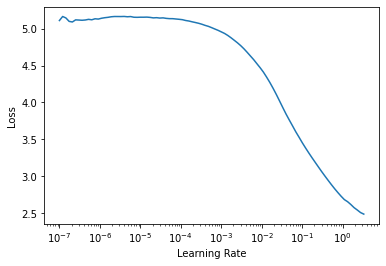

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.138251,0.152873,01:32
1,0.123864,0.460681,01:32
2,0.111477,0.260606,01:31
3,0.108601,0.279964,01:32
4,0.106521,0.167532,01:32
5,0.108525,0.198871,01:32
6,0.114971,0.149216,01:32
7,0.111681,0.186029,01:32
8,0.103782,0.201829,01:32
9,0.108229,0.154638,01:32


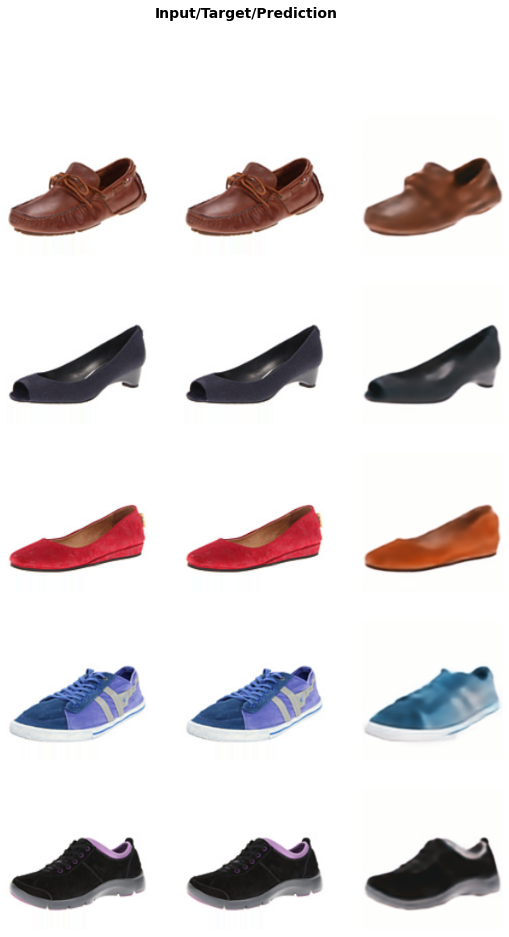

In [ ]:
learn.fit_one_cycle(30,lr_max=.2)

learn.show_results()

# Tabular Auto Encoder

In [ ]:
learn = Learner(dls, rnet_ae, loss_func=MSELossFlat())

learn.fit_one_cycle(3)

learn.show_results()





# this is the "Variational" magic.  aka the "reparamaterization trick"
class NormalSampler(Module):
    #def __init__(self):
    #super(NormalSampler,self).__init__()#not needed for Module vs nn.Module
    def forward(self,mu,logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
#         #alternative code...
#         if self.training:
#             std = logvar.mul(0.5).exp_()
#             eps = Variable(std.data.new(std.size()).normal_())
#             return eps.mul(std).add_(mu)
#         else:
#             return mu
    

class VAELinear(Module):
    def __init__(self,in_features,out_features):
        #super(VAELinear,self).__init__()#not needed for Module vs nn.Module
        self.linear = nn.Linear(in_features,out_features)
        self.mu_linear = nn.Linear(out_features,out_features)
        self.logvar_linear = nn.Linear(out_features,out_features)

    def forward(self,x):
        x = self.linear(x)
        mu = self.mu_linear(x)
        logvar = self.logvar_linear(x)

        return mu,logvar

class VAELayer(Module):
    def __init__(self,in_features,out_features):
        #super(VAELayer,self).__init__()#not needed for Module vs nn.Module
        self.blinear = VAELinear(in_features,out_features)
        self.sampler = NormalSampler()

    def forward(self,x):
        mu,logvar = self.blinear(x)
        z = self.sampler(mu,logvar)
        return z
    
class VAEBottleneck(Module):
    """    
    Wrapper to make the VAELayer play nice with the input (from encoder)
    and output (to decoder/generator)

    __init__ takes a list of "features" nominally an inputshape and output shape.  
    nfs : [128*3,latent_dimension]
    
    """
    def __init__(self,nfs:list):
        #super(VAEBottleneck,self).__init__()#not needed for Module vs nn.Module

        n = len(nfs)
        layers = [nn.Linear(in_features=nfs[i], out_features=nfs[i+1]) if i < n - 2 
             else VAELayer(in_features=nfs[i], out_features=nfs[i+1]) for i in range(n-1)]
        # just makes a single VAELayer for nfs=[128,32]
        self.fc = nn.Sequential(*layers)
    
    def forward(self,x):
        bs = x.size(0)
        x = x.view(bs, -1)
        z = self.fc(x)
        
        return z
    
    

In [ ]:
    
class ResNet_VAE(Module):
    def __init__(self, fc_hidden1=1024, fc_hidden2=512, drop_p=0.0, latent_dim=128):
        #  drop_p=0.0 default turns off dropout
        
        #super(ResNet_VAE, self).__init__()
        sig_range=[-3,3]
        self.fc_hidden1, self.fc_hidden2, self.latent_dim = fc_hidden1, fc_hidden2, latent_dim

        # CNN architechtures
        self.ch1, self.ch2, self.ch3, self.ch4 = 16, 32, 64, 128
        self.k1, self.k2, self.k3, self.k4 = (5, 5), (3, 3), (3, 3), (3, 3)      # 2d kernal size
        self.s1, self.s2, self.s3, self.s4 = (2, 2), (2, 2), (2, 2), (2, 2)      # 2d strides
        self.pd1, self.pd2, self.pd3, self.pd4 = (0, 0), (0, 0), (0, 0), (0, 0)  # 2d padding

        # encoding components
        #         resnet = models.resnet152(pretrained=True)
        #         modules = list(resnet.children())[:-1]      # delete the last fc layer.

        model = xresnet18(pretrained=True)
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))

        self.resnet = nn.Sequential(*list(model.children())[:cut])
        
        self.flatten=Flatten()
        
        self.encoder = nn.Sequential(self.resnet,self.flatten)
        
        self.fc1 = LinBnDrop(512*5*5,fc_hidden1,p=drop_p,act=nn.ReLU,lin_first=True)
        self.fc2 = LinBnDrop(fc_hidden1,fc_hidden2,p=drop_p, act=nn.ReLU,lin_first=True)

        # Latent vectors mu and sigma
        self.fc3_mu = nn.Linear(self.fc_hidden2, self.latent_dim)      # output = CNN embedding latent variables
        self.fc3_logvar = nn.Linear(self.fc_hidden2, self.latent_dim)  # output = CNN embedding latent variables

        
        # Sampling vector
        self.fc4 = nn.Sequential([nn.Linear(self.latent_dim, self.fc_hidden2),
                                  nn.BatchNorm1d(self.fc_hidden2)])
        self.fc5 = nn.Sequential([nn.Linear(self.fc_hidden2, 64 * 4 * 4),
                                    nn.BatchNorm1d(64 * 4 * 4),
                                    nn.ReLU(inplace=True)])
                
        self.sampling = nnSequential(self.fc4,self.fc5,ResizeBatch(64,4,4) )

        
        # Decoder
        self.convTrans6 = ConvLayer(ni=64,nf=32,ks=3,stride=2,padding=0,transpose=True)
        self.convTrans7 = ConvLayer(ni=32,nf=8,ks=3,stride=2,padding=0,transpose=True)
        self.convTrans8 = ConvLayer(ni=8,nf=3,ks=3,stride=2,padding=0,act_cls=SigmoidRange(*sig_range),transpose=True)
        
        self.decoder = nn.Sequential(self.sampling,self.convTrans6,self.convTrans7,self.convTrans8)
            
        #dec = nn.Sequential(SpatialDecoder2D(size),dec_convs)

        
        
        """   CURR VALUES:
        "nfs":[66,3*32,3*16,3*8,3*4,3*2,3,1,3],
        "ks": [ 3, 1, 3,1,3,1,3,1],   
        "size": IMG_SIZE 
        """
        n = len(nfs)

        # We add two channels to the first layer to include x and y channels
        first_layer = ConvBnRelu(nfs[0], #input size 
                                 nfs[1], # output size
                                 conv = PointwiseConv,
                                 bn=bn,
                                 act_fn=act_fn)

        conv_layers = [first_layer] + [ConvBnRelu(nfs[i],nfs[i+1],kernel_size=ks[i-1],
                                                  padding = ks[i-1] // 2,conv = conv,bn=bn,act_fn=act_fn)
                                       for i in range(1,n - 1)]  
        
        ConvLayer(nfs[i],nfs[i+1],kernel_size=ks[i-1],stride=2)
        dec_convs = nn.Sequential(*conv_layers)

        dec = nn.Sequential(SpatialDecoder2D(size),dec_convs)




    def encode(self, x):
        x = self.resnet(x)  # ResNet
        #x = x.view(x.size(0), -1)  # flatten output of conv
        x = self.flatten(x)
        
        # FC layers
#         x = self.bn1(self.fc1(x))
#         x = self.relu(x)
#         x = self.bn2(self.fc2(x))
#         x = self.relu(x)
        x = self.fc1(x)
        x = self.fc2(x)

        # x = F.dropout(x, p=self.drop_p, training=self.training)
        mu, logvar = self.fc3_mu(x), self.fc3_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        
#         x = self.relu(self.fc_bn4(self.fc4(z)))
#         x = self.relu(self.fc_bn5(self.fc5(x))).view(-1, 64, 4, 4)
#         x = self.convTrans6(x)
#         x = self.convTrans7(x)
#         x = self.convTrans8(x)
        x = self.decoder(x)
        x = F.interpolate(x, size=(IMG_SIZE, IMG_SIZE), mode='bilinear')
        #this is ridiculous... interpolating from 39x39 to 160x160
            
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decode(z)

        return x_reconst#, z, mu, logvar
    
    
    
# class TabularVAE(TabularModel):
#     def __init__(self, emb_szs, n_cont, hidden_size, cats, low, high, ps=0.2, embed_p=0.01, bswap=None, act_cls=Swish()):
#         super().__init__(emb_szs, n_cont, layers=[1024, 512, 256], out_sz=hidden_size, embed_p=embed_p, act_cls=act_cls)
        
#         self.bswap = bswap
#         self.cats = cats
#         self.activation_cats = sum([v for k,v in cats.items()])
        
#         self.layers = nn.Sequential(*L(self.layers.children())[:-1] + nn.Sequential(LinBnDrop(256, hidden_size, p=ps, act=act_cls)))
        
#         self.fc_mu = nn.Linear(hidden_size, hidden_size)
#         self.fc_std = nn.Linear(hidden_size, hidden_size)
        
#         if self.bswap != None: self.noise = BatchSwapNoise(self.bswap)
#         self.decoder = nn.Sequential(
#             LinBnDrop(hidden_size, 256, p=ps, act=act_cls),
#             LinBnDrop(256, 512, p=ps, act=act_cls),
#             LinBnDrop(512, 1024, p=ps, act=act_cls)
#         )
        
#         self.decoder_cont = nn.Sequential(
#             LinBnDrop(1024, n_cont, p=ps, bn=False, act=None),
#             SigmoidRange(low=low, high=high)
#         )
        
#         self.decoder_cat = LinBnDrop(1024, self.activation_cats, p=ps, bn=False, act=None)
        
#     def reparameterize(self, mu, logvar):
#         std = logvar.mul(0.5).exp_()
#         esp = torch.cuda.HalfTensor(*mu.size()).normal_()
#         z = mu + std * esp
#         return z
    
#     def bottleneck(self, h):
#         mu, logvar = self.fc_mu(h), F.softplus(self.fc_std(h))
#         z = self.reparameterize(mu, logvar)
#         return z, mu, logvar
        
#     def forward(self, x_cat, x_cont=None, encode=False):
#         if(self.bswap != None):
#             x_cat = self.noise(x_cat)
#             x_cont = self.noise(x_cont)
        
#         encoded = super().forward(x_cat, x_cont)
#         z, mu, logvar = self.bottleneck(encoded)
#         if(encode): return z
        
#         decoded_trunk = self.decoder(z)
        
#         decoded_cats = self.decoder_cat(decoded_trunk)
        
#         decoded_conts = self.decoder_cont(decoded_trunk)
        
#         return decoded_cats, decoded_conts, mu, logvar

In [ ]:
# EncoderCNN architecture
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 512
CNN_latent_dim = 128     # latent dim extracted by 2D CNN

res_size = IMG_SIZE        # ResNet image size
dropout_p = 0.2       # dropout probability

resnet_vae = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, 
                        fc_hidden2=CNN_fc_hidden2, 
                        drop_p=dropout_p,
                        latent_dim=CNN_latent_dim)

In [ ]:
#encoder = get_mnetV2_encoder()
resnet_vae.cuda()(x).shape



torch.Size([32, 3, 160, 160])

In [ ]:
x_hat,z,mu,logvar = resnet_vae.cuda()(x)

In [ ]:
x_hat.mean()

tensor(0.4992, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
mu, logvar = resnet_vae.cuda().encode(x)
z = resnet_vae.cuda().reparameterize(mu, logvar)
x_hat = resnet_vae.cuda().decode(z)

In [ ]:
x_hat.shape

torch.Size([32, 3, 160, 160])

In [ ]:
#resnet_vae.decode(z)

fc4 =nn.Linear(CNN_latent_dim, CNN_fc_hidden2).cuda()
fc_bn4 = nn.BatchNorm1d(CNN_fc_hidden2).cuda()
fc5 = nn.Linear(CNN_fc_hidden2, 64 * 4 * 4).cuda()
fc_bn5 = nn.BatchNorm1d(64 * 4 * 4).cuda()
relu = nn.ReLU(inplace=True).cuda()



x = relu(fc_bn4(fc4(z)))
x.shape

torch.Size([32, 512])

In [ ]:
x = relu(fc_bn5(fc5(x))).view(-1, 64, 4, 4)
x.shape

torch.Size([32, 64, 4, 4])

In [ ]:
x = self.convTrans6(x)
x.shape

torch.Size([32, 512])

In [ ]:
x = resnet_vae.cuda().convTrans6(x)
x.shape

torch.Size([32, 32, 9, 9])

In [ ]:
x = resnet_vae.cuda().convTrans7(x)
x.shape

torch.Size([32, 8, 19, 19])

In [ ]:
x = resnet_vae.cuda().convTrans8(x)
x.shape

torch.Size([32, 3, 39, 39])

In [ ]:
x = F.interpolate(x, size=(IMG_SIZE, IMG_SIZE), mode='bilinear')
#this is ridiculous... interpolating from 39x39 to 160x160
x.shape

torch.Size([32, 3, 160, 160])

In [ ]:
class ConvBnRelu(Module):
    def __init__(self,in_channels,out_channels,kernel_size = 3, stride = 1, bias = False, conv = nn.Conv2d,
                 bn = nn.BatchNorm2d, act_fn = nn.ReLU,**kwargs):
        #super(ConvBnRelu,self).__init__() #not needed for Module vs nn.Module
        self.conv = conv(in_channels=in_channels,out_channels=out_channels,
                         kernel_size=kernel_size,stride = stride, bias=bias,**kwargs)
        if bn:
            self.bn = bn(out_channels)
        else:
            self.bn = None
        if act_fn:
            self.act_fn = act_fn(inplace = True)
        else:
            self.act_fn = None
            
    def forward(self,x):
        output = self.conv(x)
        if self.bn:
            output = self.bn(output)
        if self.act_fn:
            output = self.act_fn(output)
        return output

    
class Downsample(Module):
    def __init__(self, pad_type='reflect', filt_size=3, stride=2, channels=None, pad_off=0):
        #super(Downsample, self).__init__() #not needed for Module vs nn.Module
        self.filt_size = filt_size
        self.pad_off = pad_off
        self.pad_sizes = [int(1.*(filt_size-1)/2), int(np.ceil(1.*(filt_size-1)/2)), int(1.*(filt_size-1)/2), int(np.ceil(1.*(filt_size-1)/2))]
        self.pad_sizes = [pad_size+pad_off for pad_size in self.pad_sizes]
        self.stride = stride
        self.off = int((self.stride-1)/2.)
        self.channels = channels

        #print('Filter size [%i]'%filt_size)
        if(self.filt_size==1):
            a = np.array([1.,])
        elif(self.filt_size==2):
            a = np.array([1., 1.])
        elif(self.filt_size==3):
            a = np.array([1., 2., 1.])
        elif(self.filt_size==4):    
            a = np.array([1., 3., 3., 1.])
        elif(self.filt_size==5):    
            a = np.array([1., 4., 6., 4., 1.])
        elif(self.filt_size==6):    
            a = np.array([1., 5., 10., 10., 5., 1.])
        elif(self.filt_size==7):    
            a = np.array([1., 6., 15., 20., 15., 6., 1.])

        filt = torch.Tensor(a[:,None]*a[None,:])
        filt = filt/torch.sum(filt)
        self.register_buffer('filt', filt[None,None,:,:].repeat((self.channels,1,1,1)))

        self.pad = nn.ReflectionPad2d(self.pad_sizes)

    def forward(self, inp):
        if(self.filt_size==1):
            if(self.pad_off==0):
                return inp[:,:,::self.stride,::self.stride]    
            else:
                return self.pad(inp)[:,:,::self.stride,::self.stride]
        else:
            return F.conv2d(self.pad(inp), self.filt, stride=self.stride, groups=inp.shape[1])

# resnet building blocks...
class ResBlock(Module):
    def __init__(self,in_channels, kernel_size=3, stride=1, padding=1, conv=ConvBnRelu,**kwargs):
        #super(ResBlock,self).__init__()#not needed for Module vs nn.Module
        self.conv1 = conv(in_channels=in_channels,out_channels=in_channels//2,kernel_size=kernel_size,
                        stride=stride,padding=padding,**kwargs)
        self.conv2 = conv(in_channels=in_channels//2,out_channels=in_channels,kernel_size=kernel_size,
                        stride=stride,padding=padding,**kwargs)
        
    def forward(self,x):
        h = self.conv2(self.conv1(x))
        return x + h
    
class DenseBlock(Module):
    def __init__(self,in_channels, kernel_size=3, stride=1, padding=1, conv=ConvBnRelu,**kwargs):
        #super(DenseBlock,self).__init__()#not needed for Module vs nn.Module
        self.conv = ResBlock(in_channels,kernel_size=kernel_size,stride=stride,padding=padding,conv=conv,**kwargs)
        
    def forward(self,x):
        h = self.conv(x)
        output = torch.cat([x,h],dim=1)
        return output

# this is the "Variational" magic.  aka the "reparamaterization trick"
class NormalSampler(Module):
    #def __init__(self):
    #super(NormalSampler,self).__init__()#not needed for Module vs nn.Module
    def forward(self,mu,logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

class VAELinear(Module):
    def __init__(self,in_features,out_features):
        #super(VAELinear,self).__init__()#not needed for Module vs nn.Module
        self.linear = nn.Linear(in_features,out_features)
        self.mu_linear = nn.Linear(out_features,out_features)
        self.logvar_linear = nn.Linear(out_features,out_features)

    def forward(self,x):
        x = self.linear(x)
        mu = self.mu_linear(x)
        logvar = self.logvar_linear(x)

        return mu,logvar

class VAELayer(Module):
    def __init__(self,in_features,out_features):
        #super(VAELayer,self).__init__()#not needed for Module vs nn.Module
        self.blinear = VAELinear(in_features,out_features)
        self.sampler = NormalSampler()

    def forward(self,x):
        mu,logvar = self.blinear(x)
        z = self.sampler(mu,logvar)
        return z
    
class VAEBottleneck(Module):
    """    
    Wrapper to make the VAELayer play nice with the input (from encoder)
    and output (to decoder/generator)

    __init__ takes a list of "features" nominally an inputshape and output shape.  
    nfs : [128*3,latent_dimension]
    
    """
    def __init__(self,nfs:list):
        #super(VAEBottleneck,self).__init__()#not needed for Module vs nn.Module

        n = len(nfs)
        layers = [nn.Linear(in_features=nfs[i], out_features=nfs[i+1]) if i < n - 2 
             else VAELayer(in_features=nfs[i], out_features=nfs[i+1]) for i in range(n-1)]
        # just makes a single VAELayer for nfs=[128,32]
        self.fc = nn.Sequential(*layers)
    
    def forward(self,x):
        bs = x.size(0)
        x = x.view(bs, -1)
        z = self.fc(x)
        
        return z
    
    
class PointwiseConv(Module):
    def __init__(self,in_channels,out_channels,bias = True,conv = nn.Conv2d,**kwargs):
        #super(PointwiseConv,self).__init__()#not needed for Module vs nn.Module
        self.conv = conv(in_channels=in_channels,out_channels=out_channels,kernel_size=1,
                         stride=1,padding=0,bias = bias)

    def forward(self,x):
        output = self.conv(x)
        return output

class SpatialDecoder2D(Module):
    def __init__(self,size):
        #super(SpatialDecoder2D,self).__init__()#not needed for Module vs nn.Module
        
        # Coordinates for the broadcast decoder
        # jah changed from 1 to 3 below
        self.size = size
        x = torch.linspace(-1, 3, size)
        y = torch.linspace(-1, 3, size)
        
        x_grid, y_grid = torch.meshgrid(x, y)
        # Add as constant, with extra dims for N and C
        self.register_buffer('x_grid', x_grid.view((1, 1) + x_grid.shape))
        self.register_buffer('y_grid', y_grid.view((1, 1) + y_grid.shape))
        
    def forward(self,z):
        batch_size = z.size(0)
        # View z as 4D tensor to be tiled across new H and W dimensions
        # Shape: NxDx1x1
        z = z.view(z.shape + (1, 1))

        # Tile across to match image size
        # Shape: NxDx64x64
        z = z.expand(-1, -1, self.size, self.size)

        # Expand grids to batches and concatenate on the channel dimension
        # Shape: Nx(D+2)x64x64
        x = torch.cat((self.x_grid.expand(batch_size, -1, -1, -1),
                       self.y_grid.expand(batch_size, -1, -1, -1), z), dim=1)

        return x
    

In [ ]:

def create_decoder(nfs, ks, size, conv=nn.Conv2d, bn=nn.BatchNorm2d, act_fn=nn.ReLU):
    """
    CURR VALUES:
    "nfs":[66,3*32,3*16,3*8,3*4,3*2,3,1,3],
    "ks": [ 3, 1, 3,1,3,1,3,1],   
    "size": IMG_SIZE 
    """
    n = len(nfs)
    
    # We add two channels to the first layer to include x and y channels
    first_layer = ConvBnRelu(nfs[0], #input size 
                             nfs[1], # output size
                             conv = PointwiseConv,
                             bn=bn,
                             act_fn=act_fn)

    conv_layers = [first_layer] + [ConvBnRelu(nfs[i],nfs[i+1],kernel_size=ks[i-1],
                                              padding = ks[i-1] // 2,conv = conv,bn=bn,act_fn=act_fn)
                                   for i in range(1,n - 1)]        
    dec_convs = nn.Sequential(*conv_layers)
    
    dec = nn.Sequential(SpatialDecoder2D(size),dec_convs)
    #SigmoidRange(*y_range)
    return dec


In [ ]:
# VAE "Bottleneck" architecture
encoder_features = 1280
latent_dimension = 64 # actually 128=64mu+64logvar
bn_args = {
    "nfs":[encoder_features,latent_dimension]
}
# 2**(c_start+1)*(IMG_SIZE*2**-c_start)**2
bottleneck = VAEBottleneck(**bn_args)


# Decoder (generator) architecture
# standard 3,1 pair of kernels
dec_args = {
#     "nfs":[66,3*32,3*16,3*8,3*4,3*2,3,1,3],
#     "ks": [ 3, 1, 3,1,3,1,3,1], 
    "nfs":[66,3*32,3*16,3*8,3*4,3*2,3],
    "ks": [ 3, 1, 3,1,3,3], 
    "size": IMG_SIZE #10 #IMG_SIZE
}
decoder = create_decoder(**dec_args)

# # simple "UpsampleBlock" decoder 
# dec_simple = decoder_simple()

        

In [ ]:
vae = nn.Sequential(encoder,bottleneck,decoder)
#arch2 = nn.Sequential(enc,bn,dec_simple)
#v_encoder = nn.Sequential(encoder,bottleneck) #variational 

In [ ]:
vae.cuda()(x).max()

tensor(3.0728, device='cuda:0', grad_fn=<MaxBackward1>)

Quick test that things are working with a generic Learner.  We'll construct some callbacks and do a more sensible loss including teh KL divergence then.

In [ ]:
learn = Learner(dls, vae, loss_func=MSELossFlat())

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,1.310135,1.351971,01:33
1,0.893036,1.059105,01:34
2,0.846967,0.763830,01:34
3,0.800514,0.774697,01:34
4,0.760596,0.744773,01:34
5,0.729769,0.700196,01:34
6,0.701213,0.670693,01:34
7,0.677020,0.700289,01:34
8,0.661608,0.640928,01:34
9,0.649680,0.637661,01:34


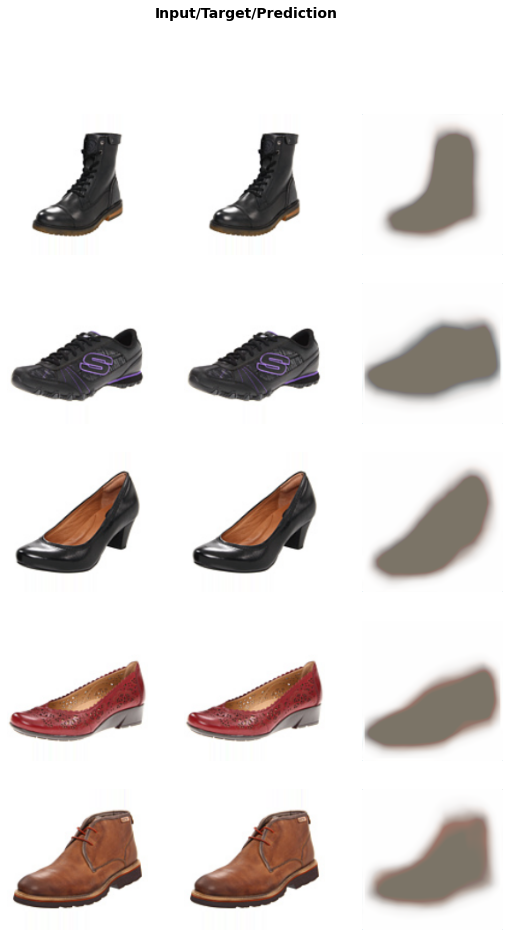

In [ ]:
learn.fit_one_cycle(10,lr_max=.01)

learn.show_results()

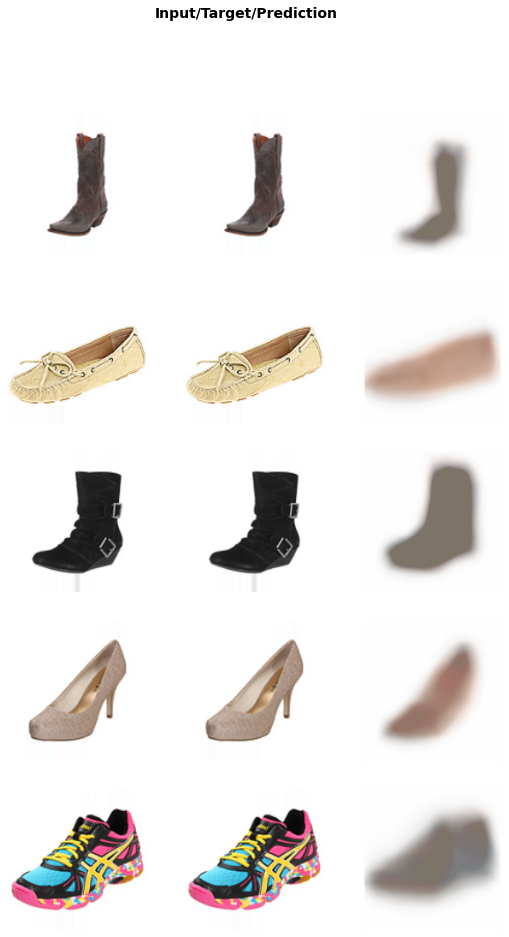

In [ ]:
learn.show_results()

In [ ]:
# Finally we'll fit for a few epochs:


learn.fit_flat_cos(config['epochs'], lr=4e-3)

In [ ]:
dl = learn.dls.test_dl(df)

In [ ]:
# Let's predict over all the data manually using PyTorch:


outs = []
for batch in dl:
    with torch.no_grad():
        learn.model.eval()
        learn.model.cuda()
        out = learn.model(*batch[:2], True).cpu().numpy()
        outs.append(out)
outs = np.concatenate(outs)



In [ ]:
y_range = (-3.,3.)
rnet_dec = decoder_resnet(y_range).cuda()

# deterministic autoencoder...
rnet_ae = nn.Sequential(rnet_body, rnet_dec)


#
# rnet_dec(arch_rnet(x)).shape,arch_rnet(x).shape,rnet_dec[0](arch_rnet(x)).shape

In [ ]:
# doc(MSELossFlat)

In [ ]:
my_args = {
    "n_dense": 3,
"c_start": 4,
"nfs_d":[66,3*32,3*16,3*8,3*4,3*2,3],
"ks_d": [ 3, 1, 3,1,3,3], 
"size": IMG_SIZE,
"hidden_size":latent_dimension}
    

my_vae = MyCVAE(**my_args)

rnet_body = create_body(xresnet18, n_in=3)

rnet_body[0:2].cuda()(x).shape

rnet_body

NameError: name 'MyCVAE' is not defined

In [ ]:
my_vae = my_vae.cuda()

x_hat = my_vae(x)

RuntimeError: mat1 dim 1 must match mat2 dim 0

Use the TabularVAE (from EtienneT) as a model for loss and callbacks for the VAE

In [ ]:
# class BatchSwapNoise(Module):
#     "Swap Noise Module"
#     def __init__(self, p): store_attr()

#     def forward(self, x):
#         if self.training:
#             mask = torch.rand(x.size()) > (1 - self.p)
#             l1 = torch.floor(torch.rand(x.size()) * x.size(0)).type(torch.LongTensor)
#             l2 = (mask.type(torch.LongTensor) * x.size(1))
#             res = (l1 * l2).view(-1)
#             idx = torch.arange(x.nelement()) + res
#             idx[idx>=x.nelement()] = idx[idx>=x.nelement()]-x.nelement()
#             return x.flatten()[idx].view(x.size())
#         else:
#             return x


class TabularVAE(Module):
    def __init__(self, emb_szs, n_cont, hidden_size, cats, low, high, 
                 ps=0.2, embed_p=0.01, bswap=None, act_cls=Swish()):
        
        
        #super().__init__(emb_szs, n_cont, layers=[1024, 512, 256], out_sz=hidden_size, embed_p=embed_p, act_cls=act_cls)
        
        self.bswap = bswap
        self.cats = cats
        self.activation_cats = sum([v for k,v in cats.items()])
        
        self.layers = nn.Sequential(*L(self.layers.children())[:-1] + nn.Sequential(LinBnDrop(256, hidden_size, p=ps, act=act_cls)))
        
        self.fc_mu = nn.Linear(hidden_size, hidden_size)
        self.fc_std = nn.Linear(hidden_size, hidden_size)
        
        if self.bswap != None: self.noise = BatchSwapNoise(self.bswap)
        self.decoder = nn.Sequential(
            LinBnDrop(hidden_size, 256, p=ps, act=act_cls),
            LinBnDrop(256, 512, p=ps, act=act_cls),
            LinBnDrop(512, 1024, p=ps, act=act_cls)
        )
        
        self.decoder_cont = nn.Sequential(
            LinBnDrop(1024, n_cont, p=ps, bn=False, act=None),
            SigmoidRange(low=low, high=high)
        )
        
        self.decoder_cat = LinBnDrop(1024, self.activation_cats, p=ps, bn=False, act=None)
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.cuda.HalfTensor(*mu.size()).normal_() #HalfTensor means 16bit
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc_mu(h), F.softplus(self.fc_std(h))
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def forward(self, x_cat, x_cont=None, encode=False):
        if(self.bswap != None):
            x_cat = self.noise(x_cat)
            x_cont = self.noise(x_cont)
        
        encoded = super().forward(x_cat, x_cont)
        z, mu, logvar = self.bottleneck(encoded)
        if(encode): return z
        
        decoded_trunk = self.decoder(z)
        
        decoded_cats = self.decoder_cat(decoded_trunk)
        
        decoded_conts = self.decoder_cont(decoded_trunk)
        
        return decoded_cats, decoded_conts, mu, logvar

In [ ]:
learn.recorder.plot_losses()

learn.show_results()

In [ ]:
# learn.recorder.plot_sched()
doc(LinBnDrop)

In [ ]:

z = v_encoder.cuda()(x)
z.shape,dec_simple[0]

#dec[0](y).shape,y.shape
#dec_simple(z).shape

(torch.Size([32, 64]),
 UpsampleBlock(
   (shuf): PixelShuffle_ICNR(
     (0): ConvLayer(
       (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
       (1): ReLU()
     )
     (1): PixelShuffle(upscale_factor=2)
   )
   (conv1): ConvLayer(
     (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
   )
   (conv2): ConvLayer(
     (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
   )
   (relu): ReLU()
 ))

In [ ]:
rnet_bn = VAEBottleneck(nfs=[512*5*5,latent_dimension])
rnet_enc = nn.Sequential(rnet_body,rnet_bn)

rnet_vae = nn.Sequential(rnet_body,rnet_bn,dec)
#rnet_vae2 = nn.Sequential(rnet_body,rnet_bn,dec_simple)  # need to fix the dec_simple...

In [ ]:
#y = rnet_body.cuda()(x)

#rnet_body.cuda()(x).shape

#y.shape,rnet_enc(x).shape

arch = arch.cuda()

In [ ]:
x_hat1 = arch(x)


In [ ]:
x_hat1.max(),x_hat1.min(),x_hat1.mean(),x_hat1.std()

(tensor(7.1724, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0., device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.3923, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.5987, device='cuda:0', grad_fn=<StdBackward0>))

In [ ]:
x.max(),x.min(),x.mean(),x.std()

(TensorImage(2.6400, device='cuda:0'),
 TensorImage(-2.0850, device='cuda:0'),
 TensorImage(1.5970, device='cuda:0'),
 TensorImage(1.4326, device='cuda:0'))

In [ ]:
rnet_vae = rnet_vae.cuda()
x_hat2 = rnet_vae(x)
x_hat2.max(),x_hat2.min(),x_hat2.mean(),x_hat2.std()


(tensor(4.1585, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0., device='cuda:0', grad_fn=<MinBackward1>),
 tensor(1.4900, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.3685, device='cuda:0', grad_fn=<StdBackward0>))

In [ ]:
(IMG_SIZE*2**-4)**2

100.0

In [ ]:
learn = Learner(dls, rnet_vae, loss_func=MSELossFlat())

(0.002290867641568184, 9.120108734350652e-05)

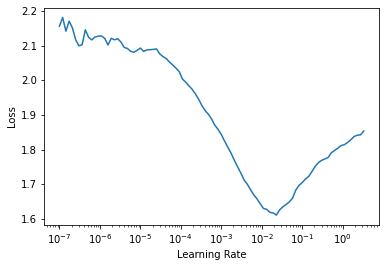

In [ ]:
lr_min, lr_steep = learn.lr_find()

lr_min,lr_steep

epoch,train_loss,valid_loss,time
0,0.503256,0.494154,02:03
1,0.470390,0.483458,02:03
2,0.453928,0.483651,02:03
3,0.445985,0.955496,02:03
4,0.426535,0.755950,02:03
5,0.426181,0.604421,02:03
6,0.415108,1.072867,02:03
7,0.398632,0.557208,02:03
8,0.395103,0.824945,02:03
9,0.383568,0.525650,02:03


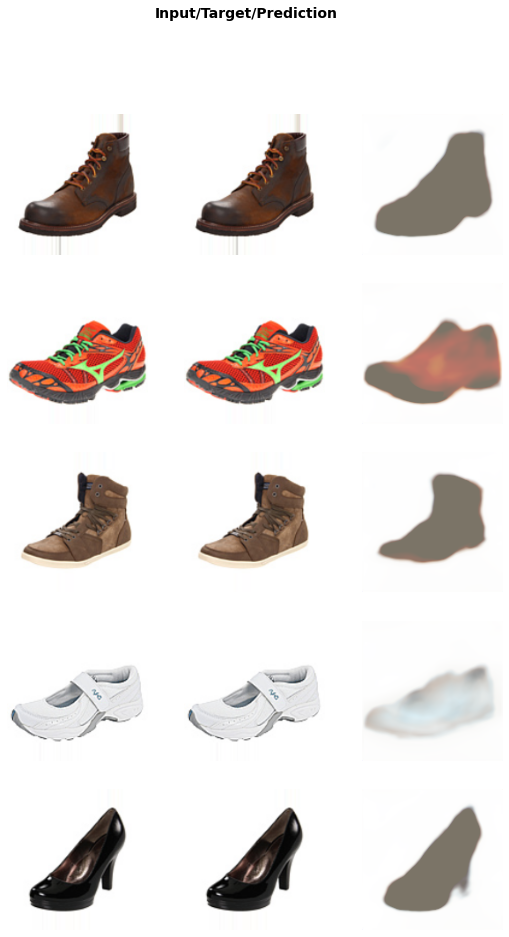

In [ ]:
learn.fit_one_cycle(25,lr_max =.0007)

learn.show_results()

In [ ]:
#input (32, 3, 160, 160)

#enc[0] (32, 4, 80, 80)
#enc[1] (32, 4, 80, 80
#enc[2] (32, 8, 40, 40
#enc[3] (32, 16, 20, 20
#enc[4] (32, 32, 10, 10


#bn input dim: 32*10*10
# output: (32, 64)

# input     (32,64)
# dec[0]    (32, 66, 160, 160)
# dec[1][0] (32, 96, 160, 160)
# dec[1][1] (32, 48, 160, 160)
# dec[1][2] (32, 24, 160, 160)
# dec[1][3] (32, 12, 160, 160)
# dec[1][4] (32, 6, 160, 160)
# dec[1][5] (32, 3, 160, 160)


#y_range = (-3.,3.)
my_ac = encoder.cuda()

my_dec = dec.cuda()


y = encoder(x)
y = my_ac(x)

dec[0](y).shape,y.shape
#my_deencoder(x)).shape
#my_ac(x).shape

RuntimeError: Tensor for 'out' is on CPU, Tensor for argument #1 'self' is on CPU, but expected them to be on GPU (while checking arguments for addmm)

In [ ]:
learn = Learner(dls, arch, loss_func=MSELossFlat(),metrics=[MSELossFlat])

In [ ]:
# We wrap the whole thing in a learner, and add a hook for the KL loss
learn = VisionAELearner(data,rec_loss,enc,bn,dec)
kl_hook = VAEHook(learn,beta=1)

# We add this code to plot the reconstructions
dec_modules = list(learn.dec[1].children())

NameError: name 'VisionAELearner' is not defined

In [ ]:
# Architectural parameters of our model
conv = nn.Conv2d
act_fn = nn.ReLU
bn = nn.BatchNorm2d
rec_loss = "mse"

# Encoder architecture
enc_fn = create_encoder_denseblock
enc_args = {
    "n_dense":3,
    "c_start" :4
}

# Bottleneck architecture
bn_fn = VAEBottleneck
bn_args = {
    "nfs":[128,32]
}

# Decoder architecture
dec_fn = create_decoder
dec_args = {
    "nfs":[32,64,32,16,8,4,2,1],
    "ks":[3,1,3,1,3,1],   
    "size": 28
}

# We create each part of the autoencoder
enc = enc_fn(**enc_args)
bn = bn_fn(**bn_args)
dec = dec_fn(**dec_args)

# We wrap the whole thing in a learner, and add a hook for the KL loss
learn = VisionAELearner(data,rec_loss,enc,bn,dec)
kl_hook = VAEHook(learn,beta=1)

# We add this code to plot the reconstructions
dec_modules = list(learn.dec[1].children())

In [ ]:
## ---------------------- ResNet VAE ---------------------- ##

class ResNet_VAE(nn.Module):
    def __init__(self, fc_hidden1=1024, fc_hidden2=768, drop_p=0.3, CNN_embed_dim=256):
        super(ResNet_VAE, self).__init__()

        self.fc_hidden1, self.fc_hidden2, self.CNN_embed_dim = fc_hidden1, fc_hidden2, CNN_embed_dim

        # CNN architechtures
        self.ch1, self.ch2, self.ch3, self.ch4 = 16, 32, 64, 128
        self.k1, self.k2, self.k3, self.k4 = (5, 5), (3, 3), (3, 3), (3, 3)      # 2d kernal size
        self.s1, self.s2, self.s3, self.s4 = (2, 2), (2, 2), (2, 2), (2, 2)      # 2d strides
        self.pd1, self.pd2, self.pd3, self.pd4 = (0, 0), (0, 0), (0, 0), (0, 0)  # 2d padding

        # encoding components
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(resnet.fc.in_features, self.fc_hidden1)
        self.bn1 = nn.BatchNorm1d(self.fc_hidden1, momentum=0.01)
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.bn2 = nn.BatchNorm1d(self.fc_hidden2, momentum=0.01)
        # Latent vectors mu and sigma
        self.fc3_mu = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)      # output = CNN embedding latent variables
        self.fc3_logvar = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)  # output = CNN embedding latent variables

        # Sampling vector
        self.fc4 = nn.Linear(self.CNN_embed_dim, self.fc_hidden2)
        self.fc_bn4 = nn.BatchNorm1d(self.fc_hidden2)
        self.fc5 = nn.Linear(self.fc_hidden2, 64 * 4 * 4)
        self.fc_bn5 = nn.BatchNorm1d(64 * 4 * 4)
        self.relu = nn.ReLU(inplace=True)

        # Decoder
        self.convTrans6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=self.k4, stride=self.s4,
                               padding=self.pd4),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
        self.convTrans7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=self.k3, stride=self.s3,
                               padding=self.pd3),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

        self.convTrans8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=self.k2, stride=self.s2,
                               padding=self.pd2),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()    # y = (y1, y2, y3) \in [0 ,1]^3
        )


    def encode(self, x):
        x = self.resnet(x)  # ResNet
        x = x.view(x.size(0), -1)  # flatten output of conv

        # FC layers
        x = self.bn1(self.fc1(x))
        x = self.relu(x)
        x = self.bn2(self.fc2(x))
        x = self.relu(x)
        # x = F.dropout(x, p=self.drop_p, training=self.training)
        mu, logvar = self.fc3_mu(x), self.fc3_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.autograd.Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        x = self.relu(self.fc_bn4(self.fc4(z)))
        x = self.relu(self.fc_bn5(self.fc5(x))).view(-1, 64, 4, 4)
        x = self.convTrans6(x)
        x = self.convTrans7(x)
        x = self.convTrans8(x)
        x = F.interpolate(x, size=(224, 224), mode='bilinear')
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decode(z)

        return x_reconst, z, mu, logvar

def conv2D_output_size(img_size, padding, kernel_size, stride):
    # compute output shape of conv2D
    outshape = (np.floor((img_size[0] + 2 * padding[0] - (kernel_size[0] - 1) - 1) / stride[0] + 1).astype(int),
                np.floor((img_size[1] + 2 * padding[1] - (kernel_size[1] - 1) - 1) / stride[1] + 1).astype(int))
    return outshape

def convtrans2D_output_size(img_size, padding, kernel_size, stride):
    # compute output shape of conv2D
    outshape = ((img_size[0] - 1) * stride[0] - 2 * padding[0] + kernel_size[0],
                (img_size[1] - 1) * stride[1] - 2 * padding[1] + kernel_size[1])
    return outshape


# EncoderCNN architecture
CNN_fc_hidden1, CNN_fc_hidden2 = 512, 512
CNN_embed_dim = 128     # latent dim extracted by 2D CNN
res_size = 160        # ResNet image size
dropout_p = 0.2       # dropout probability
# Create model
resnet_vae = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).cuda()


In [ ]:
class UpsampleBlock(Module):
    def __init__(self, up_in_c:int, final_div:bool=True, blur:bool=False, leaky:float=None, **kwargs):
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, **kwargs)
        ni = up_in_c//2
        nf = ni if final_div else ni//2
        self.conv1 = ConvLayer(ni, nf, **kwargs)
        self.conv2 = ConvLayer(nf, nf, **kwargs)
        self.relu = nn.ReLU()

    def forward(self, up_in:Tensor) -> Tensor:
        up_out = self.shuf(up_in)
        cat_x = self.relu(up_out)
        return self.conv2(self.conv1(cat_x))
    
    def shuff(self,x:Tensor) -> Tensor:
        up_out = self.shuf(up_in)
        cat_x = self.relu(up_out)
        return cat_x
    
#doc(PixelShuffle_ICNR)

def decoder_resnet(y_range, n_out=3):
    return nn.Sequential(UpsampleBlock(512), 
                         UpsampleBlock(256),
                         UpsampleBlock(128),
                         UpsampleBlock(64),
                         UpsampleBlock(32),
                         nn.Conv2d(16, n_out, 1),
                         SigmoidRange(*y_range)
                        )
                         

In [ ]:
# 

class MyCVAE(Module):
    def __init__(self,#nfs_e,ks_e,
                    n_dense,c_start,
                    nfs_d,ks_d,size,
                    hidden_size, #latent_size
                    conv=nn.Conv2d,bn=nn.BatchNorm2d,act_fn = nn.ReLU):
        #         """
        #         constructor for generic convolutional encoder 
        #         """
        #         n = len(nfs)
        #         conv_layers = [nn.Sequential(ConvBnRelu(nfs[i],nfs[i+1],kernel_size=ks[i],
        #                                                 conv = conv,bn=bn,act_fn=act_fn, padding = ks[i] //2 ),
        #                                      Downsample(channels=nfs[i+1],filt_size=3,stride=2))
        #                                        for i in range(n-1)]        
        #         reg_encoder = nn.Sequential(*conv_layers)

        #def create_encoder_denseblock(n_dense,c_start):
        """
        n_dense": 3,
        "c_start": 4
        """
        first_layer = nn.Sequential(ConvBnRelu(3,c_start,kernel_size=3,padding = 1),
                                    ResBlock(c_start),
                                    Downsample(channels=4,filt_size=3,stride=2))

        layers = [first_layer] + [
            nn.Sequential(
                DenseBlock(c_start * (2**c)),
                Downsample(channels=c_start * (2**(c+1)),filt_size=3,stride=2)) for c in range(n_dense)
                ]

        dense_encoder = nn.Sequential(*layers)


        #create_decoder(nfs, ks, size, conv=nn.Conv2d, bn=nn.BatchNorm2d, act_fn=nn.ReLU):
        """
        "nfs":[66,3*32,3*16,3*8,3*4,3*2,3,1,3],
        "ks": [ 3, 1, 3,1,3,1,3,1],   
        "size": IMG_SIZE 
        """
        nfs = nfs_d
        ks = ks_d
        n = len(nfs)

        # We add two channels to the first layer to include x and y channels
        first_layer = ConvBnRelu(nfs[0], #input size 
                                 nfs[1], # output size
                                 conv = PointwiseConv,
                                 bn=bn,
                                 act_fn=act_fn)

        conv_layers = [first_layer] + [ConvBnRelu(nfs[i],nfs[i+1],kernel_size=ks[i-1],
                                                  padding = ks[i-1] // 2,conv = conv,bn=bn,act_fn=act_fn)
                                       for i in range(1,n - 1)]        
        dec_convs = nn.Sequential(*conv_layers)
        dec = nn.Sequential(SpatialDecoder2D(size),dec_convs)
  
        self.fc_mu = nn.Linear(hidden_size, hidden_size)
        self.fc_std = nn.Linear(hidden_size, hidden_size)
        
            
        self.decoder = dec
        self.encoder = dense_encoder
        
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.cuda.HalfTensor(*mu.size()).normal_()
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc_mu(h), F.softplus(self.fc_std(h))
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def forward(self,x,encode=False):
        
        encoded = self.encoder(x) #recursive call to get the noise ?!?!
        z, mu, logvar = self.bottleneck(encoded)
        if(encode): return z
        
        decoded = self.decoder(z)

        return decoded, mu, logvar

    
    
## ARCHITECUTE
def create_encoder(nfs,ks,conv=nn.Conv2d,bn=nn.BatchNorm2d,act_fn = nn.ReLU):
    """
    constructor for generic convolutional encoder 
    """
    n = len(nfs)
    conv_layers = [nn.Sequential(ConvBnRelu(nfs[i],nfs[i+1],kernel_size=ks[i],
                                            conv = conv,bn=bn,act_fn=act_fn, padding = ks[i] //2 ),
                                 Downsample(channels=nfs[i+1],filt_size=3,stride=2))
                                   for i in range(n-1)]        
    convs = nn.Sequential(*conv_layers)
    return convs

def create_encoder_denseblock(n_dense,c_start):
    """
    constructor for resnet with dense blocks  (?) 

    n_dense": 3,
    "c_start": 4
    """
    first_layer = nn.Sequential(ConvBnRelu(3,c_start,kernel_size=3,padding = 1),
                                ResBlock(c_start),
                                Downsample(channels=4,filt_size=3,stride=2))
    
    layers = [first_layer] + [
        nn.Sequential(
            DenseBlock(c_start * (2**c)),
            Downsample(channels=c_start * (2**(c+1)),filt_size=3,stride=2)) for c in range(n_dense)
    ]
    
    model = nn.Sequential(*layers)
    
    return model

def create_decoder(nfs, ks, size, conv=nn.Conv2d, bn=nn.BatchNorm2d, act_fn=nn.ReLU):
    """
    CURR VALUES:
    "nfs":[66,3*32,3*16,3*8,3*4,3*2,3,1,3],
    "ks": [ 3, 1, 3,1,3,1,3,1],   
    "size": IMG_SIZE 
    """
    n = len(nfs)
    
    # We add two channels to the first layer to include x and y channels
    first_layer = ConvBnRelu(nfs[0], #input size 
                             nfs[1], # output size
                             conv = PointwiseConv,
                             bn=bn,
                             act_fn=act_fn)

    conv_layers = [first_layer] + [ConvBnRelu(nfs[i],nfs[i+1],kernel_size=ks[i-1],
                                              padding = ks[i-1] // 2,conv = conv,bn=bn,act_fn=act_fn)
                                   for i in range(1,n - 1)]        
    dec_convs = nn.Sequential(*conv_layers)
    
    dec = nn.Sequential(SpatialDecoder2D(size),dec_convs)
    #SigmoidRange(*y_range)
    return dec

def decoder_simple(y_range=[-3,3], n_out=3):
    return nn.Sequential(#UpsampleBlock(64),
                         UpsampleBlock(32),
                         nn.Conv2d(16, n_out, 1),
                         SigmoidRange(*y_range)
                        )